# Vehicle Detection

## Histogram of Oriented Gradients (HOG)

Total # images:  17760
Total # of notcars:  8968
Total # of cars:  8792


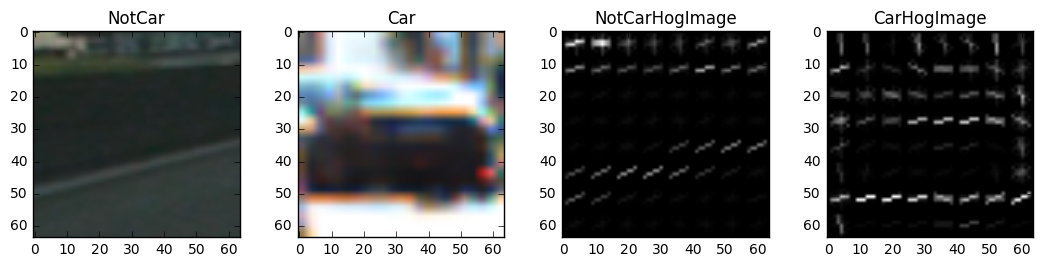

In [33]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog
import glob

%matplotlib inline

# Define some global variables which we use through the whole notebook

global orient
global pix_per_cell
global cell_per_block
global ystart
global ystop
global scale
global spatial_size
global hist_bins

global cspace
global test_img
global heat_threshold

# Set the parameters, starting out with the parameters we also used in the video-lecture (best-practices)

orient = 11  # HOG orientation - (typical values between 6-12)
pix_per_cell = 8 # HOG pixels per cell - (commonly square but not necessarily)
cell_per_block = 2 # HOG cells per block
ystart = 400 # Exclude non interesting area start
ystop = 656 # Exclude non interesting area stop
scale = 1.5 
spatial_size = (32, 32)
hist_bins = 32

cspace = "RGB2YUV"
test_img = mpimg.imread("test_images/test1.jpg")
heat_threshold = 3

# HOG Features

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Read in car and non-car images

images = glob.glob("/Users/manuelstuefer/PycharmProjects/CarND-Vehicle-Detection/images/*/*/*.png")
print("Total # images: ", len(images))
cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

print("Total # of notcars: ", len(notcars))
print("Total # of cars: ", len(cars))

img_ind = np.random.randint(0, min(len(cars), len(notcars)))

# Show a random non-vehicle (NotCar) and a vehicle (Car) with corresponding HOG Image

notcar = mpimg.imread(notcars[img_ind])
gnotcar = cv2.cvtColor(notcar, cv2.COLOR_RGB2GRAY)
_, notcar_hog_image = get_hog_features(gnotcar, orient, pix_per_cell, cell_per_block, True, True)

car = mpimg.imread(cars[img_ind])
gcar = cv2.cvtColor(car, cv2.COLOR_RGB2GRAY)
_, car_hog_image = get_hog_features(gcar, orient, pix_per_cell, cell_per_block, True, True)

f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 8))
f.tight_layout()
ax1.imshow(notcar, cmap='gray')
ax1.set_title('NotCar', fontsize=12)
ax2.imshow(car, cmap='gray')
ax2.set_title('Car', fontsize=12)
ax3.imshow(notcar_hog_image, cmap='gray')
ax3.set_title('NotCarHogImage', fontsize=12)
ax4.imshow(car_hog_image, cmap='gray')
ax4.set_title('CarHogImage', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Linear Support Vector Classifier

In [12]:
# Classifier training

from sklearn.grid_search import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

param_grid = [
    # {'C': [1, 10], 'gamma': [0.001, 0.0001]}
    # {'C': [1, 10, 100], 'kernel': ['linear'], 'gamma': [0.001, 0.0001]}
    # {'C': [1, 10, 100, 1000], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.0001], 
    # {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
 ]

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def extract_features(imgs, spatial_size=(32, 32), hist_bins=32):
    global cspace
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = image.astype(np.float32)/255
        feature_image = convert_color(image, cspace)
        
        # ALL hog_channel
        ch1 = feature_image[:,:,0]
        ch2 = feature_image[:,:,1]
        ch3 = feature_image[:,:,2]        
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False).ravel()
        hog_features = np.hstack((hog1, hog2, hog3))
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    # Return list of feature vectors
    return features

car_features = extract_features(cars, spatial_size=spatial_size, hist_bins=hist_bins)
notcar_features = extract_features(notcars, spatial_size=spatial_size, hist_bins=hist_bins)

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    print(scaled_X.shape)
    # Define labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
    # Use a linear SVC 
    svc = LinearSVC()
    # svc = SVC()
    # clf = GridSearchCV(svc, param_grid)
    # Train
    svc.fit(X_train, y_train)
    # clf.fit(X_train, y_train)
    # print('Best params found = ', clf.best_params_)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
else: 
    raise ValueError("car_features empty")

(17760, 9636)


Test Accuracy of SVC =  0.9896


## Find Cars 

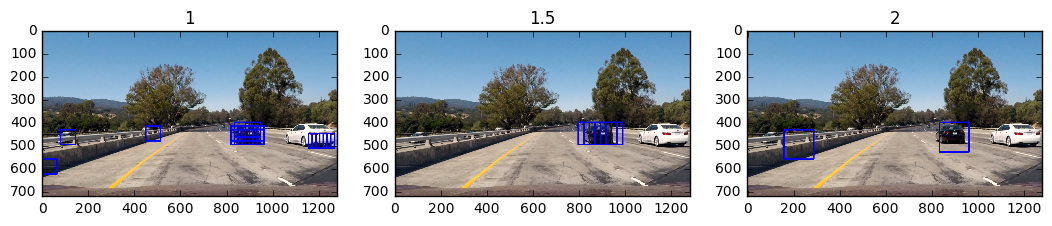

In [34]:
# Sliding Window Search

def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    global cspace
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    bbox = []

    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    # ALL hog_channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                box = ((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart))
                cv2.rectangle(draw_img,box[0],box[1],(0,0,255),6)
                bbox.append(box)

    return draw_img, bbox


final_box_list = []
scale = 2
out_img20, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)
scale = 1.5
out_img15, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)
scale = 1
out_img10, box_list = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
final_box_list.append(box_list)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 8))
f.tight_layout()
ax1.imshow(out_img10)
ax1.set_title('1', fontsize=12)
ax2.imshow(out_img15)
ax2.set_title('1.5', fontsize=12)
ax3.imshow(out_img20)
ax3.set_title('2', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
final_box_list = [item for sublist in final_box_list for item in sublist]

## Heatmap to reduce FP 

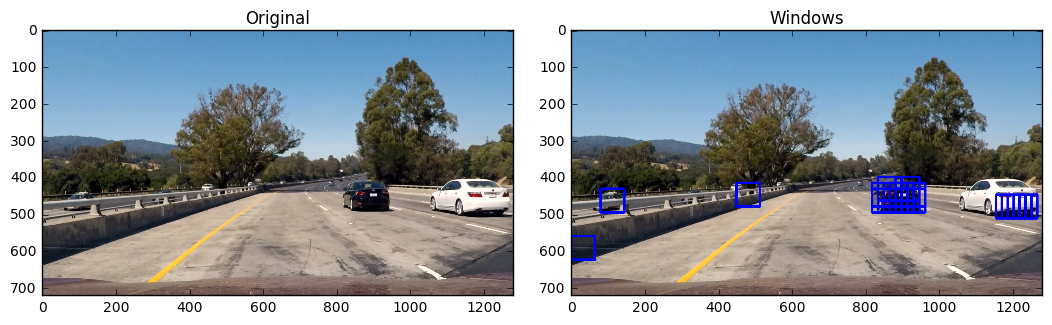

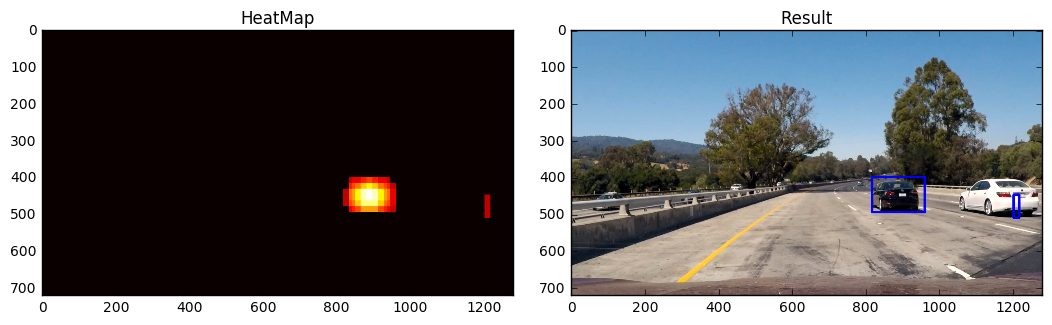

In [36]:
# Heatmap

from scipy.ndimage.measurements import label

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,final_box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,heat_threshold)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

# plt.imshow(heatmap, cmap="hot")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax1.imshow(test_img, cmap='gray')
ax1.set_title('Original', fontsize=12)
ax2.imshow(out_img10, cmap='gray')
ax2.set_title('Windows', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(10, 8))
f.tight_layout()
ax3.imshow(heatmap, cmap='hot')
ax3.set_title('HeatMap', fontsize=12)
ax4.imshow(draw_img, cmap='gray')
ax4.set_title('Result', fontsize=12)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Video Image Pipeline

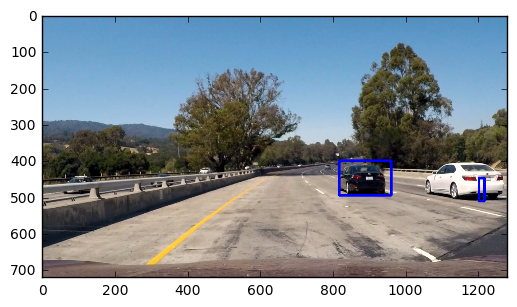

In [38]:
# Video ImagePipeline

def process_image(original_image):
    global heat_threshold
    
    final_box_list = []
    scale = 1
    out_img10, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)
    
    scale = 1.5
    out_img15, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)

    scale = 2
    out_img20, box_list = find_cars(original_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    final_box_list.append(box_list)
    
    final_box_list = [item for sublist in final_box_list for item in sublist]
    
    heat = np.zeros_like(original_image[:,:,0]).astype(np.float)
    heat = add_heat(heat,final_box_list)
    heat = apply_threshold(heat,heat_threshold)
    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
        
    draw_img = draw_labeled_bboxes(np.copy(original_image), labels)
    return draw_img

plt.imshow(process_image(test_img))

## Video

In [39]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output = "project_output_video.mp4"
clip = VideoFileClip("./project_video.mp4")
new_clip = clip.fl_image(process_image)
new_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4


[MoviePy] Writing video project_output_video.mp4




  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:01<41:55,  2.00s/it]



  0%|          | 2/1261 [00:03<41:39,  1.99s/it]



  0%|          | 3/1261 [00:06<42:20,  2.02s/it]



  0%|          | 4/1261 [00:08<42:57,  2.05s/it]



  0%|          | 5/1261 [00:10<44:38,  2.13s/it]



  0%|          | 6/1261 [00:12<45:14,  2.16s/it]



  1%|          | 7/1261 [00:15<50:13,  2.40s/it]



  1%|          | 8/1261 [00:18<50:31,  2.42s/it]



  1%|          | 9/1261 [00:20<49:07,  2.35s/it]



  1%|          | 10/1261 [00:22<47:53,  2.30s/it]



  1%|          | 11/1261 [00:24<47:51,  2.30s/it]



  1%|          | 12/1261 [00:26<46:44,  2.25s/it]



  1%|          | 13/1261 [00:29<45:41,  2.20s/it]



  1%|          | 14/1261 [00:31<45:21,  2.18s/it]



  1%|          | 15/1261 [00:33<45:44,  2.20s/it]



  1%|▏         | 16/1261 [00:35<45:30,  2.19s/it]



  1%|▏         | 17/1261 [00:37<45:22,  2.19s/it]



  1%|▏         | 18/1261 [00:40<45:46,  2.21s/it]



  2%|▏         | 19/1261 [00:42<46:22,  2.24s/it]



  2%|▏         | 20/1261 [00:44<46:14,  2.24s/it]



  2%|▏         | 21/1261 [00:46<47:08,  2.28s/it]



  2%|▏         | 22/1261 [00:49<49:24,  2.39s/it]



  2%|▏         | 23/1261 [00:51<47:07,  2.28s/it]



  2%|▏         | 24/1261 [00:53<45:56,  2.23s/it]



  2%|▏         | 25/1261 [00:55<45:41,  2.22s/it]



  2%|▏         | 26/1261 [00:57<44:09,  2.15s/it]



  2%|▏         | 27/1261 [01:00<44:51,  2.18s/it]



  2%|▏         | 28/1261 [01:02<44:32,  2.17s/it]



  2%|▏         | 29/1261 [01:04<44:55,  2.19s/it]



  2%|▏         | 30/1261 [01:06<44:53,  2.19s/it]



  2%|▏         | 31/1261 [01:08<44:29,  2.17s/it]



  3%|▎         | 32/1261 [01:11<44:49,  2.19s/it]



  3%|▎         | 33/1261 [01:13<45:34,  2.23s/it]



  3%|▎         | 34/1261 [01:15<46:09,  2.26s/it]



  3%|▎         | 35/1261 [01:17<45:46,  2.24s/it]



  3%|▎         | 36/1261 [01:20<46:00,  2.25s/it]



  3%|▎         | 37/1261 [01:22<44:14,  2.17s/it]



  3%|▎         | 38/1261 [01:24<42:49,  2.10s/it]



  3%|▎         | 39/1261 [01:26<43:42,  2.15s/it]



  3%|▎         | 40/1261 [01:28<42:44,  2.10s/it]



  3%|▎         | 41/1261 [01:30<41:50,  2.06s/it]



  3%|▎         | 42/1261 [01:32<41:46,  2.06s/it]



  3%|▎         | 43/1261 [01:34<41:44,  2.06s/it]



  3%|▎         | 44/1261 [01:36<41:10,  2.03s/it]



  4%|▎         | 45/1261 [01:38<41:10,  2.03s/it]



  4%|▎         | 46/1261 [01:40<43:05,  2.13s/it]



  4%|▎         | 47/1261 [01:43<43:44,  2.16s/it]



  4%|▍         | 48/1261 [01:45<43:39,  2.16s/it]



  4%|▍         | 49/1261 [01:47<44:19,  2.19s/it]



  4%|▍         | 50/1261 [01:49<43:21,  2.15s/it]



  4%|▍         | 51/1261 [01:51<43:32,  2.16s/it]



  4%|▍         | 52/1261 [01:54<44:29,  2.21s/it]



  4%|▍         | 53/1261 [01:56<44:59,  2.23s/it]



  4%|▍         | 54/1261 [01:58<44:23,  2.21s/it]



  4%|▍         | 55/1261 [02:00<45:26,  2.26s/it]



  4%|▍         | 56/1261 [02:03<45:21,  2.26s/it]



  5%|▍         | 57/1261 [02:05<45:47,  2.28s/it]



  5%|▍         | 58/1261 [02:07<44:51,  2.24s/it]



  5%|▍         | 59/1261 [02:09<45:08,  2.25s/it]



  5%|▍         | 60/1261 [02:12<45:12,  2.26s/it]



  5%|▍         | 61/1261 [02:14<43:58,  2.20s/it]



  5%|▍         | 62/1261 [02:16<43:22,  2.17s/it]



  5%|▍         | 63/1261 [02:18<44:00,  2.20s/it]



  5%|▌         | 64/1261 [02:20<43:54,  2.20s/it]



  5%|▌         | 65/1261 [02:22<43:03,  2.16s/it]



  5%|▌         | 66/1261 [02:24<42:30,  2.13s/it]



  5%|▌         | 67/1261 [02:27<43:30,  2.19s/it]



  5%|▌         | 68/1261 [02:29<43:43,  2.20s/it]



  5%|▌         | 69/1261 [02:31<43:28,  2.19s/it]



  6%|▌         | 70/1261 [02:34<45:02,  2.27s/it]



  6%|▌         | 71/1261 [02:36<44:11,  2.23s/it]



  6%|▌         | 72/1261 [02:38<44:14,  2.23s/it]



  6%|▌         | 73/1261 [02:41<46:36,  2.35s/it]



  6%|▌         | 74/1261 [02:43<47:18,  2.39s/it]



  6%|▌         | 75/1261 [02:45<45:59,  2.33s/it]



  6%|▌         | 76/1261 [02:47<44:32,  2.26s/it]



  6%|▌         | 77/1261 [02:50<46:09,  2.34s/it]



  6%|▌         | 78/1261 [02:52<46:42,  2.37s/it]



  6%|▋         | 79/1261 [02:55<46:30,  2.36s/it]



  6%|▋         | 80/1261 [02:57<47:34,  2.42s/it]



  6%|▋         | 81/1261 [03:00<47:00,  2.39s/it]



  7%|▋         | 82/1261 [03:02<45:59,  2.34s/it]



  7%|▋         | 83/1261 [03:04<45:47,  2.33s/it]



  7%|▋         | 84/1261 [03:06<46:17,  2.36s/it]



  7%|▋         | 85/1261 [03:09<46:09,  2.35s/it]



  7%|▋         | 86/1261 [03:11<44:39,  2.28s/it]



  7%|▋         | 87/1261 [03:13<44:19,  2.26s/it]



  7%|▋         | 88/1261 [03:15<43:46,  2.24s/it]



  7%|▋         | 89/1261 [03:18<44:08,  2.26s/it]



  7%|▋         | 90/1261 [03:20<45:08,  2.31s/it]



  7%|▋         | 91/1261 [03:23<45:42,  2.34s/it]



  7%|▋         | 92/1261 [03:26<52:15,  2.68s/it]



  7%|▋         | 93/1261 [03:29<55:05,  2.83s/it]



  7%|▋         | 94/1261 [03:32<55:16,  2.84s/it]



  8%|▊         | 95/1261 [03:35<53:10,  2.74s/it]



  8%|▊         | 96/1261 [03:37<50:59,  2.63s/it]



  8%|▊         | 97/1261 [03:39<49:15,  2.54s/it]



  8%|▊         | 98/1261 [03:41<46:44,  2.41s/it]



  8%|▊         | 99/1261 [03:44<45:44,  2.36s/it]



  8%|▊         | 100/1261 [03:46<45:20,  2.34s/it]



  8%|▊         | 101/1261 [03:48<45:18,  2.34s/it]



  8%|▊         | 102/1261 [03:50<44:35,  2.31s/it]



  8%|▊         | 103/1261 [03:53<44:28,  2.30s/it]



  8%|▊         | 104/1261 [03:55<43:17,  2.25s/it]



  8%|▊         | 105/1261 [03:57<42:34,  2.21s/it]



  8%|▊         | 106/1261 [03:59<40:57,  2.13s/it]



  8%|▊         | 107/1261 [04:01<39:36,  2.06s/it]



  9%|▊         | 108/1261 [04:03<38:55,  2.03s/it]



  9%|▊         | 109/1261 [04:05<39:43,  2.07s/it]



  9%|▊         | 110/1261 [04:07<39:28,  2.06s/it]



  9%|▉         | 111/1261 [04:09<38:51,  2.03s/it]



  9%|▉         | 112/1261 [04:11<39:46,  2.08s/it]



  9%|▉         | 113/1261 [04:13<40:26,  2.11s/it]



  9%|▉         | 114/1261 [04:15<40:04,  2.10s/it]



  9%|▉         | 115/1261 [04:18<40:47,  2.14s/it]



  9%|▉         | 116/1261 [04:20<40:28,  2.12s/it]



  9%|▉         | 117/1261 [04:22<40:50,  2.14s/it]



  9%|▉         | 118/1261 [04:24<39:57,  2.10s/it]



  9%|▉         | 119/1261 [04:26<39:07,  2.06s/it]



 10%|▉         | 120/1261 [04:28<38:39,  2.03s/it]



 10%|▉         | 121/1261 [04:30<38:04,  2.00s/it]



 10%|▉         | 122/1261 [04:32<38:33,  2.03s/it]



 10%|▉         | 123/1261 [04:34<39:19,  2.07s/it]



 10%|▉         | 124/1261 [04:36<40:31,  2.14s/it]



 10%|▉         | 125/1261 [04:39<41:20,  2.18s/it]



 10%|▉         | 126/1261 [04:41<40:55,  2.16s/it]



 10%|█         | 127/1261 [04:43<39:55,  2.11s/it]



 10%|█         | 128/1261 [04:45<40:23,  2.14s/it]



 10%|█         | 129/1261 [04:47<40:19,  2.14s/it]



 10%|█         | 130/1261 [04:49<40:33,  2.15s/it]



 10%|█         | 131/1261 [04:51<40:52,  2.17s/it]



 10%|█         | 132/1261 [04:54<41:06,  2.18s/it]



 11%|█         | 133/1261 [04:56<41:34,  2.21s/it]



 11%|█         | 134/1261 [04:58<42:29,  2.26s/it]



 11%|█         | 135/1261 [05:00<41:49,  2.23s/it]



 11%|█         | 136/1261 [05:03<42:00,  2.24s/it]



 11%|█         | 137/1261 [05:05<41:56,  2.24s/it]



 11%|█         | 138/1261 [05:07<42:27,  2.27s/it]



 11%|█         | 139/1261 [05:10<43:13,  2.31s/it]



 11%|█         | 140/1261 [05:12<43:37,  2.33s/it]



 11%|█         | 141/1261 [05:15<44:17,  2.37s/it]



 11%|█▏        | 142/1261 [05:17<42:29,  2.28s/it]



 11%|█▏        | 143/1261 [05:19<41:13,  2.21s/it]



 11%|█▏        | 144/1261 [05:21<42:01,  2.26s/it]



 11%|█▏        | 145/1261 [05:23<42:16,  2.27s/it]



 12%|█▏        | 146/1261 [05:25<41:37,  2.24s/it]



 12%|█▏        | 147/1261 [05:28<42:01,  2.26s/it]



 12%|█▏        | 148/1261 [05:30<42:13,  2.28s/it]



 12%|█▏        | 149/1261 [05:32<42:38,  2.30s/it]



 12%|█▏        | 150/1261 [05:35<42:53,  2.32s/it]



 12%|█▏        | 151/1261 [05:38<46:16,  2.50s/it]



 12%|█▏        | 152/1261 [05:40<47:24,  2.57s/it]



 12%|█▏        | 153/1261 [05:43<47:37,  2.58s/it]



 12%|█▏        | 154/1261 [05:46<47:13,  2.56s/it]



 12%|█▏        | 155/1261 [05:48<46:42,  2.53s/it]



 12%|█▏        | 156/1261 [05:51<46:17,  2.51s/it]



 12%|█▏        | 157/1261 [05:53<45:24,  2.47s/it]



 13%|█▎        | 158/1261 [05:55<43:51,  2.39s/it]



 13%|█▎        | 159/1261 [05:57<43:00,  2.34s/it]



 13%|█▎        | 160/1261 [05:59<41:10,  2.24s/it]



 13%|█▎        | 161/1261 [06:01<39:50,  2.17s/it]



 13%|█▎        | 162/1261 [06:03<38:43,  2.11s/it]



 13%|█▎        | 163/1261 [06:05<38:51,  2.12s/it]



 13%|█▎        | 164/1261 [06:08<39:29,  2.16s/it]



 13%|█▎        | 165/1261 [06:10<40:31,  2.22s/it]



 13%|█▎        | 166/1261 [06:12<39:58,  2.19s/it]



 13%|█▎        | 167/1261 [06:14<38:45,  2.13s/it]



 13%|█▎        | 168/1261 [06:16<38:08,  2.09s/it]



 13%|█▎        | 169/1261 [06:18<38:10,  2.10s/it]



 13%|█▎        | 170/1261 [06:21<39:02,  2.15s/it]



 14%|█▎        | 171/1261 [06:23<39:59,  2.20s/it]



 14%|█▎        | 172/1261 [06:25<39:31,  2.18s/it]



 14%|█▎        | 173/1261 [06:27<39:48,  2.20s/it]



 14%|█▍        | 174/1261 [06:29<39:36,  2.19s/it]



 14%|█▍        | 175/1261 [06:32<39:06,  2.16s/it]



 14%|█▍        | 176/1261 [06:34<38:28,  2.13s/it]



 14%|█▍        | 177/1261 [06:36<38:48,  2.15s/it]



 14%|█▍        | 178/1261 [06:38<38:23,  2.13s/it]



 14%|█▍        | 179/1261 [06:40<38:07,  2.11s/it]



 14%|█▍        | 180/1261 [06:42<38:32,  2.14s/it]



 14%|█▍        | 181/1261 [06:44<39:03,  2.17s/it]



 14%|█▍        | 182/1261 [06:46<38:43,  2.15s/it]



 15%|█▍        | 183/1261 [06:48<37:48,  2.10s/it]



 15%|█▍        | 184/1261 [06:51<37:57,  2.11s/it]



 15%|█▍        | 185/1261 [06:53<37:27,  2.09s/it]



 15%|█▍        | 186/1261 [06:55<36:46,  2.05s/it]



 15%|█▍        | 187/1261 [06:57<37:57,  2.12s/it]



 15%|█▍        | 188/1261 [06:59<36:58,  2.07s/it]



 15%|█▍        | 189/1261 [07:01<37:06,  2.08s/it]



 15%|█▌        | 190/1261 [07:03<37:59,  2.13s/it]



 15%|█▌        | 191/1261 [07:05<37:56,  2.13s/it]



 15%|█▌        | 192/1261 [07:08<38:57,  2.19s/it]



 15%|█▌        | 193/1261 [07:10<39:58,  2.25s/it]



 15%|█▌        | 194/1261 [07:13<41:22,  2.33s/it]



 15%|█▌        | 195/1261 [07:15<41:09,  2.32s/it]



 16%|█▌        | 196/1261 [07:17<40:05,  2.26s/it]



 16%|█▌        | 197/1261 [07:19<38:24,  2.17s/it]



 16%|█▌        | 198/1261 [07:21<37:01,  2.09s/it]



 16%|█▌        | 199/1261 [07:23<37:16,  2.11s/it]



 16%|█▌        | 200/1261 [07:25<37:01,  2.09s/it]



 16%|█▌        | 201/1261 [07:27<36:49,  2.08s/it]



 16%|█▌        | 202/1261 [07:29<36:54,  2.09s/it]



 16%|█▌        | 203/1261 [07:32<38:20,  2.17s/it]



 16%|█▌        | 204/1261 [07:34<38:35,  2.19s/it]



 16%|█▋        | 205/1261 [07:36<37:43,  2.14s/it]



 16%|█▋        | 206/1261 [07:38<37:48,  2.15s/it]



 16%|█▋        | 207/1261 [07:40<38:31,  2.19s/it]



 16%|█▋        | 208/1261 [07:42<37:25,  2.13s/it]



 17%|█▋        | 209/1261 [07:44<36:22,  2.07s/it]



 17%|█▋        | 210/1261 [07:46<35:34,  2.03s/it]



 17%|█▋        | 211/1261 [07:48<35:19,  2.02s/it]



 17%|█▋        | 212/1261 [07:50<35:02,  2.00s/it]



 17%|█▋        | 213/1261 [07:52<34:47,  1.99s/it]



 17%|█▋        | 214/1261 [07:54<34:51,  2.00s/it]



 17%|█▋        | 215/1261 [07:56<34:46,  1.99s/it]



 17%|█▋        | 216/1261 [07:58<36:18,  2.08s/it]



 17%|█▋        | 217/1261 [08:01<36:57,  2.12s/it]



 17%|█▋        | 218/1261 [08:03<37:02,  2.13s/it]



 17%|█▋        | 219/1261 [08:05<37:40,  2.17s/it]



 17%|█▋        | 220/1261 [08:07<38:32,  2.22s/it]



 18%|█▊        | 221/1261 [08:09<38:02,  2.19s/it]



 18%|█▊        | 222/1261 [08:12<38:48,  2.24s/it]



 18%|█▊        | 223/1261 [08:14<39:16,  2.27s/it]



 18%|█▊        | 224/1261 [08:16<38:54,  2.25s/it]



 18%|█▊        | 225/1261 [08:18<37:51,  2.19s/it]



 18%|█▊        | 226/1261 [08:21<37:56,  2.20s/it]



 18%|█▊        | 227/1261 [08:23<37:28,  2.17s/it]



 18%|█▊        | 228/1261 [08:25<36:56,  2.15s/it]



 18%|█▊        | 229/1261 [08:27<37:10,  2.16s/it]



 18%|█▊        | 230/1261 [08:29<36:16,  2.11s/it]



 18%|█▊        | 231/1261 [08:31<36:40,  2.14s/it]



 18%|█▊        | 232/1261 [08:34<37:42,  2.20s/it]



 18%|█▊        | 233/1261 [08:36<37:30,  2.19s/it]



 19%|█▊        | 234/1261 [08:38<36:53,  2.16s/it]



 19%|█▊        | 235/1261 [08:40<37:00,  2.16s/it]



 19%|█▊        | 236/1261 [08:42<36:51,  2.16s/it]



 19%|█▉        | 237/1261 [08:44<36:24,  2.13s/it]



 19%|█▉        | 238/1261 [08:46<35:49,  2.10s/it]



 19%|█▉        | 239/1261 [08:48<35:32,  2.09s/it]



 19%|█▉        | 240/1261 [08:51<36:33,  2.15s/it]



 19%|█▉        | 241/1261 [08:53<36:37,  2.15s/it]



 19%|█▉        | 242/1261 [08:55<36:55,  2.17s/it]



 19%|█▉        | 243/1261 [08:57<36:25,  2.15s/it]



 19%|█▉        | 244/1261 [08:59<36:18,  2.14s/it]



 19%|█▉        | 245/1261 [09:02<38:34,  2.28s/it]



 20%|█▉        | 246/1261 [09:04<40:09,  2.37s/it]



 20%|█▉        | 247/1261 [09:07<41:42,  2.47s/it]



 20%|█▉        | 248/1261 [09:09<40:48,  2.42s/it]



 20%|█▉        | 249/1261 [09:11<39:03,  2.32s/it]



 20%|█▉        | 250/1261 [09:14<38:32,  2.29s/it]



 20%|█▉        | 251/1261 [09:16<39:28,  2.35s/it]



 20%|█▉        | 252/1261 [09:18<39:19,  2.34s/it]



 20%|██        | 253/1261 [09:21<40:17,  2.40s/it]



 20%|██        | 254/1261 [09:23<39:48,  2.37s/it]



 20%|██        | 255/1261 [09:27<44:24,  2.65s/it]



 20%|██        | 256/1261 [09:29<42:04,  2.51s/it]



 20%|██        | 257/1261 [09:31<40:04,  2.39s/it]



 20%|██        | 258/1261 [09:33<37:55,  2.27s/it]



 21%|██        | 259/1261 [09:35<36:51,  2.21s/it]



 21%|██        | 260/1261 [09:37<35:53,  2.15s/it]



 21%|██        | 261/1261 [09:39<34:48,  2.09s/it]



 21%|██        | 262/1261 [09:41<34:06,  2.05s/it]



 21%|██        | 263/1261 [09:43<33:43,  2.03s/it]



 21%|██        | 264/1261 [09:45<33:37,  2.02s/it]



 21%|██        | 265/1261 [09:47<33:49,  2.04s/it]



 21%|██        | 266/1261 [09:49<33:58,  2.05s/it]



 21%|██        | 267/1261 [09:51<35:06,  2.12s/it]



 21%|██▏       | 268/1261 [09:54<36:28,  2.20s/it]



 21%|██▏       | 269/1261 [09:56<36:44,  2.22s/it]



 21%|██▏       | 270/1261 [09:58<36:22,  2.20s/it]



 21%|██▏       | 271/1261 [10:00<36:26,  2.21s/it]



 22%|██▏       | 272/1261 [10:03<36:20,  2.20s/it]



 22%|██▏       | 273/1261 [10:05<36:08,  2.19s/it]



 22%|██▏       | 274/1261 [10:07<35:53,  2.18s/it]



 22%|██▏       | 275/1261 [10:09<36:00,  2.19s/it]



 22%|██▏       | 276/1261 [10:12<38:09,  2.32s/it]



 22%|██▏       | 277/1261 [10:14<38:53,  2.37s/it]



 22%|██▏       | 278/1261 [10:17<39:25,  2.41s/it]



 22%|██▏       | 279/1261 [10:19<40:41,  2.49s/it]



 22%|██▏       | 280/1261 [10:22<41:00,  2.51s/it]



 22%|██▏       | 281/1261 [10:24<41:01,  2.51s/it]



 22%|██▏       | 282/1261 [10:27<40:45,  2.50s/it]



 22%|██▏       | 283/1261 [10:29<40:59,  2.51s/it]



 23%|██▎       | 284/1261 [10:32<41:05,  2.52s/it]



 23%|██▎       | 285/1261 [10:34<40:02,  2.46s/it]



 23%|██▎       | 286/1261 [10:36<37:26,  2.30s/it]



 23%|██▎       | 287/1261 [10:38<35:31,  2.19s/it]



 23%|██▎       | 288/1261 [10:40<35:41,  2.20s/it]



 23%|██▎       | 289/1261 [10:43<36:44,  2.27s/it]



 23%|██▎       | 290/1261 [10:45<38:02,  2.35s/it]



 23%|██▎       | 291/1261 [10:48<37:59,  2.35s/it]



 23%|██▎       | 292/1261 [10:50<36:26,  2.26s/it]



 23%|██▎       | 293/1261 [10:52<35:00,  2.17s/it]



 23%|██▎       | 294/1261 [10:54<34:58,  2.17s/it]



 23%|██▎       | 295/1261 [10:57<41:07,  2.55s/it]



 23%|██▎       | 296/1261 [11:00<40:16,  2.50s/it]



 24%|██▎       | 297/1261 [11:02<39:20,  2.45s/it]



 24%|██▎       | 298/1261 [11:04<38:41,  2.41s/it]



 24%|██▎       | 299/1261 [11:07<38:36,  2.41s/it]



 24%|██▍       | 300/1261 [11:09<38:59,  2.43s/it]



 24%|██▍       | 301/1261 [11:12<40:13,  2.51s/it]



 24%|██▍       | 302/1261 [11:15<41:20,  2.59s/it]



 24%|██▍       | 303/1261 [11:17<41:19,  2.59s/it]



 24%|██▍       | 304/1261 [11:20<41:23,  2.59s/it]



 24%|██▍       | 305/1261 [11:23<42:44,  2.68s/it]



 24%|██▍       | 306/1261 [11:26<43:49,  2.75s/it]



 24%|██▍       | 307/1261 [11:29<46:10,  2.90s/it]



 24%|██▍       | 308/1261 [11:31<42:34,  2.68s/it]



 25%|██▍       | 309/1261 [11:34<45:25,  2.86s/it]



 25%|██▍       | 310/1261 [11:37<44:07,  2.78s/it]



 25%|██▍       | 311/1261 [11:39<42:35,  2.69s/it]



 25%|██▍       | 312/1261 [11:42<41:27,  2.62s/it]



 25%|██▍       | 313/1261 [11:44<41:05,  2.60s/it]



 25%|██▍       | 314/1261 [11:47<39:56,  2.53s/it]



 25%|██▍       | 315/1261 [11:49<39:39,  2.51s/it]



 25%|██▌       | 316/1261 [11:52<38:46,  2.46s/it]



 25%|██▌       | 317/1261 [11:55<42:19,  2.69s/it]



 25%|██▌       | 318/1261 [11:58<42:08,  2.68s/it]



 25%|██▌       | 319/1261 [12:00<41:19,  2.63s/it]



 25%|██▌       | 320/1261 [12:03<40:28,  2.58s/it]



 25%|██▌       | 321/1261 [12:05<38:01,  2.43s/it]



 26%|██▌       | 322/1261 [12:08<41:36,  2.66s/it]



 26%|██▌       | 323/1261 [12:11<45:17,  2.90s/it]



 26%|██▌       | 324/1261 [12:14<42:55,  2.75s/it]



 26%|██▌       | 325/1261 [12:16<41:21,  2.65s/it]



 26%|██▌       | 326/1261 [12:18<39:58,  2.57s/it]



 26%|██▌       | 327/1261 [12:21<39:36,  2.54s/it]



 26%|██▌       | 328/1261 [12:23<38:24,  2.47s/it]



 26%|██▌       | 329/1261 [12:25<36:30,  2.35s/it]



 26%|██▌       | 330/1261 [12:28<36:12,  2.33s/it]



 26%|██▌       | 331/1261 [12:30<36:01,  2.32s/it]



 26%|██▋       | 332/1261 [12:32<37:01,  2.39s/it]



 26%|██▋       | 333/1261 [12:35<37:31,  2.43s/it]



 26%|██▋       | 334/1261 [12:38<39:43,  2.57s/it]



 27%|██▋       | 335/1261 [12:40<38:35,  2.50s/it]



 27%|██▋       | 336/1261 [12:42<37:07,  2.41s/it]



 27%|██▋       | 337/1261 [12:45<35:53,  2.33s/it]



 27%|██▋       | 338/1261 [12:47<35:43,  2.32s/it]



 27%|██▋       | 339/1261 [12:49<35:08,  2.29s/it]



 27%|██▋       | 340/1261 [12:51<33:40,  2.19s/it]



 27%|██▋       | 341/1261 [12:53<33:52,  2.21s/it]



 27%|██▋       | 342/1261 [12:55<33:25,  2.18s/it]



 27%|██▋       | 343/1261 [12:58<33:26,  2.19s/it]



 27%|██▋       | 344/1261 [13:00<34:30,  2.26s/it]



 27%|██▋       | 345/1261 [13:02<34:04,  2.23s/it]



 27%|██▋       | 346/1261 [13:05<35:12,  2.31s/it]



 28%|██▊       | 347/1261 [13:08<41:28,  2.72s/it]



 28%|██▊       | 348/1261 [13:11<39:59,  2.63s/it]



 28%|██▊       | 349/1261 [13:13<37:49,  2.49s/it]



 28%|██▊       | 350/1261 [13:15<36:36,  2.41s/it]



 28%|██▊       | 351/1261 [13:17<36:10,  2.39s/it]



 28%|██▊       | 352/1261 [13:20<35:24,  2.34s/it]



 28%|██▊       | 353/1261 [13:22<34:27,  2.28s/it]



 28%|██▊       | 354/1261 [13:24<33:30,  2.22s/it]



 28%|██▊       | 355/1261 [13:26<33:51,  2.24s/it]



 28%|██▊       | 356/1261 [13:28<33:48,  2.24s/it]



 28%|██▊       | 357/1261 [13:31<34:17,  2.28s/it]



 28%|██▊       | 358/1261 [13:33<33:09,  2.20s/it]



 28%|██▊       | 359/1261 [13:35<31:52,  2.12s/it]



 29%|██▊       | 360/1261 [13:37<31:10,  2.08s/it]



 29%|██▊       | 361/1261 [13:39<30:31,  2.03s/it]



 29%|██▊       | 362/1261 [13:41<30:25,  2.03s/it]



 29%|██▉       | 363/1261 [13:43<29:59,  2.00s/it]



 29%|██▉       | 364/1261 [13:45<29:51,  2.00s/it]



 29%|██▉       | 365/1261 [13:47<29:37,  1.98s/it]



 29%|██▉       | 366/1261 [13:49<29:48,  2.00s/it]



 29%|██▉       | 367/1261 [13:51<29:45,  2.00s/it]



 29%|██▉       | 368/1261 [13:53<29:32,  1.98s/it]



 29%|██▉       | 369/1261 [13:55<29:21,  1.97s/it]



 29%|██▉       | 370/1261 [13:57<29:20,  1.98s/it]



 29%|██▉       | 371/1261 [13:58<29:08,  1.96s/it]



 30%|██▉       | 372/1261 [14:00<29:09,  1.97s/it]



 30%|██▉       | 373/1261 [14:02<29:20,  1.98s/it]



 30%|██▉       | 374/1261 [14:04<29:09,  1.97s/it]



 30%|██▉       | 375/1261 [14:06<28:58,  1.96s/it]



 30%|██▉       | 376/1261 [14:08<28:49,  1.95s/it]



 30%|██▉       | 377/1261 [14:10<28:37,  1.94s/it]



 30%|██▉       | 378/1261 [14:12<29:05,  1.98s/it]



 30%|███       | 379/1261 [14:14<28:59,  1.97s/it]



 30%|███       | 380/1261 [14:16<28:43,  1.96s/it]



 30%|███       | 381/1261 [14:18<28:45,  1.96s/it]



 30%|███       | 382/1261 [14:20<28:36,  1.95s/it]



 30%|███       | 383/1261 [14:22<28:26,  1.94s/it]



 30%|███       | 384/1261 [14:24<28:23,  1.94s/it]



 31%|███       | 385/1261 [14:26<28:29,  1.95s/it]



 31%|███       | 386/1261 [14:28<28:27,  1.95s/it]



 31%|███       | 387/1261 [14:30<28:26,  1.95s/it]



 31%|███       | 388/1261 [14:32<28:18,  1.95s/it]



 31%|███       | 389/1261 [14:34<28:14,  1.94s/it]



 31%|███       | 390/1261 [14:36<28:18,  1.95s/it]



 31%|███       | 391/1261 [14:38<28:06,  1.94s/it]



 31%|███       | 392/1261 [14:39<28:08,  1.94s/it]



 31%|███       | 393/1261 [14:41<28:16,  1.95s/it]



 31%|███       | 394/1261 [14:44<28:57,  2.00s/it]



 31%|███▏      | 395/1261 [14:46<29:57,  2.08s/it]



 31%|███▏      | 396/1261 [14:48<29:40,  2.06s/it]



 31%|███▏      | 397/1261 [14:50<29:11,  2.03s/it]



 32%|███▏      | 398/1261 [14:52<29:30,  2.05s/it]



 32%|███▏      | 399/1261 [14:54<29:00,  2.02s/it]



 32%|███▏      | 400/1261 [14:56<29:01,  2.02s/it]



 32%|███▏      | 401/1261 [14:58<29:55,  2.09s/it]



 32%|███▏      | 402/1261 [15:01<34:01,  2.38s/it]



 32%|███▏      | 403/1261 [15:04<34:09,  2.39s/it]



 32%|███▏      | 404/1261 [15:06<32:55,  2.31s/it]



 32%|███▏      | 405/1261 [15:09<35:19,  2.48s/it]



 32%|███▏      | 406/1261 [15:11<34:50,  2.45s/it]



 32%|███▏      | 407/1261 [15:13<32:57,  2.32s/it]



 32%|███▏      | 408/1261 [15:16<34:31,  2.43s/it]



 32%|███▏      | 409/1261 [15:18<33:38,  2.37s/it]



 33%|███▎      | 410/1261 [15:20<31:55,  2.25s/it]



 33%|███▎      | 411/1261 [15:22<31:40,  2.24s/it]



 33%|███▎      | 412/1261 [15:24<31:51,  2.25s/it]



 33%|███▎      | 413/1261 [15:27<33:23,  2.36s/it]



 33%|███▎      | 414/1261 [15:29<34:03,  2.41s/it]



 33%|███▎      | 415/1261 [15:32<33:09,  2.35s/it]



 33%|███▎      | 416/1261 [15:34<32:16,  2.29s/it]



 33%|███▎      | 417/1261 [15:36<32:11,  2.29s/it]



 33%|███▎      | 418/1261 [15:38<31:34,  2.25s/it]



 33%|███▎      | 419/1261 [15:40<31:09,  2.22s/it]



 33%|███▎      | 420/1261 [15:42<30:17,  2.16s/it]



 33%|███▎      | 421/1261 [15:44<29:36,  2.12s/it]



 33%|███▎      | 422/1261 [15:47<29:24,  2.10s/it]



 34%|███▎      | 423/1261 [15:49<29:28,  2.11s/it]



 34%|███▎      | 424/1261 [15:51<29:54,  2.14s/it]



 34%|███▎      | 425/1261 [15:53<30:06,  2.16s/it]



 34%|███▍      | 426/1261 [15:55<29:55,  2.15s/it]



 34%|███▍      | 427/1261 [15:57<30:06,  2.17s/it]



 34%|███▍      | 428/1261 [16:00<30:23,  2.19s/it]



 34%|███▍      | 429/1261 [16:02<30:55,  2.23s/it]



 34%|███▍      | 430/1261 [16:04<30:46,  2.22s/it]



 34%|███▍      | 431/1261 [16:06<30:47,  2.23s/it]



 34%|███▍      | 432/1261 [16:09<31:19,  2.27s/it]



 34%|███▍      | 433/1261 [16:11<30:43,  2.23s/it]



 34%|███▍      | 434/1261 [16:13<30:05,  2.18s/it]



 34%|███▍      | 435/1261 [16:15<29:38,  2.15s/it]



 35%|███▍      | 436/1261 [16:18<31:14,  2.27s/it]



 35%|███▍      | 437/1261 [16:20<32:22,  2.36s/it]



 35%|███▍      | 438/1261 [16:22<31:55,  2.33s/it]



 35%|███▍      | 439/1261 [16:25<30:51,  2.25s/it]



 35%|███▍      | 440/1261 [16:27<30:10,  2.21s/it]



 35%|███▍      | 441/1261 [16:29<29:39,  2.17s/it]



 35%|███▌      | 442/1261 [16:31<29:04,  2.13s/it]



 35%|███▌      | 443/1261 [16:33<29:49,  2.19s/it]



 35%|███▌      | 444/1261 [16:35<29:53,  2.20s/it]



 35%|███▌      | 445/1261 [16:37<29:53,  2.20s/it]



 35%|███▌      | 446/1261 [16:40<30:11,  2.22s/it]



 35%|███▌      | 447/1261 [16:42<30:34,  2.25s/it]



 36%|███▌      | 448/1261 [16:44<30:39,  2.26s/it]



 36%|███▌      | 449/1261 [16:46<29:46,  2.20s/it]



 36%|███▌      | 450/1261 [16:49<29:20,  2.17s/it]



 36%|███▌      | 451/1261 [16:51<30:10,  2.24s/it]



 36%|███▌      | 452/1261 [16:53<30:42,  2.28s/it]



 36%|███▌      | 453/1261 [16:56<31:53,  2.37s/it]



 36%|███▌      | 454/1261 [16:58<32:34,  2.42s/it]



 36%|███▌      | 455/1261 [17:01<32:23,  2.41s/it]



 36%|███▌      | 456/1261 [17:03<32:43,  2.44s/it]



 36%|███▌      | 457/1261 [17:06<32:40,  2.44s/it]



 36%|███▋      | 458/1261 [17:08<32:44,  2.45s/it]



 36%|███▋      | 459/1261 [17:11<32:58,  2.47s/it]



 36%|███▋      | 460/1261 [17:13<32:12,  2.41s/it]



 37%|███▋      | 461/1261 [17:16<33:02,  2.48s/it]



 37%|███▋      | 462/1261 [17:18<32:47,  2.46s/it]



 37%|███▋      | 463/1261 [17:21<33:08,  2.49s/it]



 37%|███▋      | 464/1261 [17:23<32:42,  2.46s/it]



 37%|███▋      | 465/1261 [17:25<32:38,  2.46s/it]



 37%|███▋      | 466/1261 [17:28<32:38,  2.46s/it]



 37%|███▋      | 467/1261 [17:30<31:47,  2.40s/it]



 37%|███▋      | 468/1261 [17:33<31:45,  2.40s/it]



 37%|███▋      | 469/1261 [17:35<31:45,  2.41s/it]



 37%|███▋      | 470/1261 [17:38<33:46,  2.56s/it]



 37%|███▋      | 471/1261 [17:41<36:23,  2.76s/it]



 37%|███▋      | 472/1261 [17:43<34:32,  2.63s/it]



 38%|███▊      | 473/1261 [17:46<33:11,  2.53s/it]



 38%|███▊      | 474/1261 [17:48<32:29,  2.48s/it]



 38%|███▊      | 475/1261 [17:51<32:11,  2.46s/it]



 38%|███▊      | 476/1261 [17:53<31:53,  2.44s/it]



 38%|███▊      | 477/1261 [17:55<32:00,  2.45s/it]



 38%|███▊      | 478/1261 [17:58<31:38,  2.42s/it]



 38%|███▊      | 479/1261 [18:00<31:26,  2.41s/it]



 38%|███▊      | 480/1261 [18:03<31:28,  2.42s/it]



 38%|███▊      | 481/1261 [18:05<30:59,  2.38s/it]



 38%|███▊      | 482/1261 [18:07<30:44,  2.37s/it]



 38%|███▊      | 483/1261 [18:10<30:30,  2.35s/it]



 38%|███▊      | 484/1261 [18:12<30:03,  2.32s/it]



 38%|███▊      | 485/1261 [18:14<30:08,  2.33s/it]



 39%|███▊      | 486/1261 [18:16<29:58,  2.32s/it]



 39%|███▊      | 487/1261 [18:19<30:11,  2.34s/it]



 39%|███▊      | 488/1261 [18:21<30:11,  2.34s/it]



 39%|███▉      | 489/1261 [18:24<30:09,  2.34s/it]



 39%|███▉      | 490/1261 [18:26<30:10,  2.35s/it]



 39%|███▉      | 491/1261 [18:28<30:07,  2.35s/it]



 39%|███▉      | 492/1261 [18:31<29:56,  2.34s/it]



 39%|███▉      | 493/1261 [18:33<30:04,  2.35s/it]



 39%|███▉      | 494/1261 [18:35<30:05,  2.35s/it]



 39%|███▉      | 495/1261 [18:38<29:56,  2.35s/it]



 39%|███▉      | 496/1261 [18:40<29:57,  2.35s/it]



 39%|███▉      | 497/1261 [18:42<29:47,  2.34s/it]



 39%|███▉      | 498/1261 [18:45<29:40,  2.33s/it]



 40%|███▉      | 499/1261 [18:47<29:42,  2.34s/it]



 40%|███▉      | 500/1261 [18:49<29:22,  2.32s/it]



 40%|███▉      | 501/1261 [18:52<29:15,  2.31s/it]



 40%|███▉      | 502/1261 [18:54<29:13,  2.31s/it]



 40%|███▉      | 503/1261 [18:56<29:10,  2.31s/it]



 40%|███▉      | 504/1261 [18:59<29:19,  2.32s/it]



 40%|████      | 505/1261 [19:01<29:10,  2.32s/it]



 40%|████      | 506/1261 [19:03<29:31,  2.35s/it]



 40%|████      | 507/1261 [19:06<29:22,  2.34s/it]



 40%|████      | 508/1261 [19:08<29:14,  2.33s/it]



 40%|████      | 509/1261 [19:10<29:19,  2.34s/it]



 40%|████      | 510/1261 [19:13<29:37,  2.37s/it]



 41%|████      | 511/1261 [19:15<29:24,  2.35s/it]



 41%|████      | 512/1261 [19:17<29:38,  2.37s/it]



 41%|████      | 513/1261 [19:20<29:29,  2.37s/it]



 41%|████      | 514/1261 [19:22<29:27,  2.37s/it]



 41%|████      | 515/1261 [19:24<29:28,  2.37s/it]



 41%|████      | 516/1261 [19:27<29:22,  2.37s/it]



 41%|████      | 517/1261 [19:29<29:12,  2.36s/it]



 41%|████      | 518/1261 [19:32<29:20,  2.37s/it]



 41%|████      | 519/1261 [19:34<29:31,  2.39s/it]



 41%|████      | 520/1261 [19:36<29:38,  2.40s/it]



 41%|████▏     | 521/1261 [19:39<29:25,  2.39s/it]



 41%|████▏     | 522/1261 [19:41<29:23,  2.39s/it]



 41%|████▏     | 523/1261 [19:44<29:08,  2.37s/it]



 42%|████▏     | 524/1261 [19:46<28:57,  2.36s/it]



 42%|████▏     | 525/1261 [19:48<29:01,  2.37s/it]



 42%|████▏     | 526/1261 [19:51<29:06,  2.38s/it]



 42%|████▏     | 527/1261 [19:53<28:52,  2.36s/it]



 42%|████▏     | 528/1261 [19:55<28:50,  2.36s/it]



 42%|████▏     | 529/1261 [19:58<28:58,  2.37s/it]



 42%|████▏     | 530/1261 [20:00<28:57,  2.38s/it]



 42%|████▏     | 531/1261 [20:02<28:56,  2.38s/it]



 42%|████▏     | 532/1261 [20:05<28:35,  2.35s/it]



 42%|████▏     | 533/1261 [20:07<28:30,  2.35s/it]



 42%|████▏     | 534/1261 [20:09<28:31,  2.35s/it]



 42%|████▏     | 535/1261 [20:12<28:35,  2.36s/it]



 43%|████▎     | 536/1261 [20:14<28:11,  2.33s/it]



 43%|████▎     | 537/1261 [20:17<28:25,  2.36s/it]



 43%|████▎     | 538/1261 [20:19<28:35,  2.37s/it]



 43%|████▎     | 539/1261 [20:21<28:31,  2.37s/it]



 43%|████▎     | 540/1261 [20:24<28:17,  2.35s/it]



 43%|████▎     | 541/1261 [20:26<28:13,  2.35s/it]



 43%|████▎     | 542/1261 [20:28<28:12,  2.35s/it]



 43%|████▎     | 543/1261 [20:31<27:50,  2.33s/it]



 43%|████▎     | 544/1261 [20:33<28:19,  2.37s/it]



 43%|████▎     | 545/1261 [20:36<29:49,  2.50s/it]



 43%|████▎     | 546/1261 [20:38<30:09,  2.53s/it]



 43%|████▎     | 547/1261 [20:41<29:32,  2.48s/it]



 43%|████▎     | 548/1261 [20:43<29:07,  2.45s/it]



 44%|████▎     | 549/1261 [20:46<28:50,  2.43s/it]



 44%|████▎     | 550/1261 [20:48<28:39,  2.42s/it]



 44%|████▎     | 551/1261 [20:50<28:35,  2.42s/it]



 44%|████▍     | 552/1261 [20:53<28:40,  2.43s/it]



 44%|████▍     | 553/1261 [20:55<28:21,  2.40s/it]



 44%|████▍     | 554/1261 [20:58<28:14,  2.40s/it]



 44%|████▍     | 555/1261 [21:00<28:02,  2.38s/it]



 44%|████▍     | 556/1261 [21:02<28:06,  2.39s/it]



 44%|████▍     | 557/1261 [21:05<27:55,  2.38s/it]



 44%|████▍     | 558/1261 [21:07<28:00,  2.39s/it]



 44%|████▍     | 559/1261 [21:10<28:54,  2.47s/it]



 44%|████▍     | 560/1261 [21:12<29:30,  2.53s/it]



 44%|████▍     | 561/1261 [21:15<29:27,  2.52s/it]



 45%|████▍     | 562/1261 [21:17<29:13,  2.51s/it]



 45%|████▍     | 563/1261 [21:20<28:41,  2.47s/it]



 45%|████▍     | 564/1261 [21:23<29:46,  2.56s/it]



 45%|████▍     | 565/1261 [21:25<29:38,  2.56s/it]



 45%|████▍     | 566/1261 [21:27<28:42,  2.48s/it]



 45%|████▍     | 567/1261 [21:30<28:21,  2.45s/it]



 45%|████▌     | 568/1261 [21:32<28:05,  2.43s/it]



 45%|████▌     | 569/1261 [21:35<27:48,  2.41s/it]



 45%|████▌     | 570/1261 [21:37<27:34,  2.39s/it]



 45%|████▌     | 571/1261 [21:39<27:27,  2.39s/it]



 45%|████▌     | 572/1261 [21:42<27:23,  2.38s/it]



 45%|████▌     | 573/1261 [21:44<27:03,  2.36s/it]



 46%|████▌     | 574/1261 [21:46<27:10,  2.37s/it]



 46%|████▌     | 575/1261 [21:49<27:52,  2.44s/it]



 46%|████▌     | 576/1261 [21:51<27:38,  2.42s/it]



 46%|████▌     | 577/1261 [21:54<27:23,  2.40s/it]



 46%|████▌     | 578/1261 [21:56<27:39,  2.43s/it]



 46%|████▌     | 579/1261 [21:59<27:21,  2.41s/it]



 46%|████▌     | 580/1261 [22:01<27:13,  2.40s/it]



 46%|████▌     | 581/1261 [22:03<26:57,  2.38s/it]



 46%|████▌     | 582/1261 [22:06<26:52,  2.37s/it]



 46%|████▌     | 583/1261 [22:08<26:37,  2.36s/it]



 46%|████▋     | 584/1261 [22:10<26:54,  2.38s/it]



 46%|████▋     | 585/1261 [22:13<26:57,  2.39s/it]



 46%|████▋     | 586/1261 [22:15<26:29,  2.35s/it]



 47%|████▋     | 587/1261 [22:18<26:51,  2.39s/it]



 47%|████▋     | 588/1261 [22:20<26:48,  2.39s/it]



 47%|████▋     | 589/1261 [22:22<26:27,  2.36s/it]



 47%|████▋     | 590/1261 [22:25<26:37,  2.38s/it]



 47%|████▋     | 591/1261 [22:27<26:23,  2.36s/it]



 47%|████▋     | 592/1261 [22:29<26:06,  2.34s/it]



 47%|████▋     | 593/1261 [22:32<26:11,  2.35s/it]



 47%|████▋     | 594/1261 [22:34<26:01,  2.34s/it]



 47%|████▋     | 595/1261 [22:36<25:52,  2.33s/it]



 47%|████▋     | 596/1261 [22:38<25:10,  2.27s/it]



 47%|████▋     | 597/1261 [22:41<24:53,  2.25s/it]



 47%|████▋     | 598/1261 [22:43<24:43,  2.24s/it]



 48%|████▊     | 599/1261 [22:45<24:20,  2.21s/it]



 48%|████▊     | 600/1261 [22:47<24:16,  2.20s/it]



 48%|████▊     | 601/1261 [22:49<24:03,  2.19s/it]



 48%|████▊     | 602/1261 [22:51<23:52,  2.17s/it]



 48%|████▊     | 603/1261 [22:54<23:53,  2.18s/it]



 48%|████▊     | 604/1261 [22:56<23:38,  2.16s/it]



 48%|████▊     | 605/1261 [22:58<23:41,  2.17s/it]



 48%|████▊     | 606/1261 [23:00<23:58,  2.20s/it]



 48%|████▊     | 607/1261 [23:02<23:55,  2.19s/it]



 48%|████▊     | 608/1261 [23:05<23:49,  2.19s/it]



 48%|████▊     | 609/1261 [23:07<23:31,  2.17s/it]



 48%|████▊     | 610/1261 [23:09<23:33,  2.17s/it]



 48%|████▊     | 611/1261 [23:11<23:27,  2.17s/it]



 49%|████▊     | 612/1261 [23:13<23:23,  2.16s/it]



 49%|████▊     | 613/1261 [23:15<23:21,  2.16s/it]



 49%|████▊     | 614/1261 [23:17<23:10,  2.15s/it]



 49%|████▉     | 615/1261 [23:20<23:30,  2.18s/it]



 49%|████▉     | 616/1261 [23:22<23:40,  2.20s/it]



 49%|████▉     | 617/1261 [23:24<23:45,  2.21s/it]



 49%|████▉     | 618/1261 [23:26<23:32,  2.20s/it]



 49%|████▉     | 619/1261 [23:28<23:22,  2.18s/it]



 49%|████▉     | 620/1261 [23:31<23:12,  2.17s/it]



 49%|████▉     | 621/1261 [23:33<23:27,  2.20s/it]



 49%|████▉     | 622/1261 [23:35<23:20,  2.19s/it]



 49%|████▉     | 623/1261 [23:37<23:00,  2.16s/it]



 49%|████▉     | 624/1261 [23:39<23:02,  2.17s/it]



 50%|████▉     | 625/1261 [23:42<23:22,  2.20s/it]



 50%|████▉     | 626/1261 [23:44<23:12,  2.19s/it]



 50%|████▉     | 627/1261 [23:46<23:06,  2.19s/it]



 50%|████▉     | 628/1261 [23:48<23:01,  2.18s/it]



 50%|████▉     | 629/1261 [23:50<22:55,  2.18s/it]



 50%|████▉     | 630/1261 [23:52<22:39,  2.15s/it]



 50%|█████     | 631/1261 [23:55<22:35,  2.15s/it]



 50%|█████     | 632/1261 [23:57<22:36,  2.16s/it]



 50%|█████     | 633/1261 [23:59<22:20,  2.13s/it]



 50%|█████     | 634/1261 [24:01<22:30,  2.15s/it]



 50%|█████     | 635/1261 [24:03<22:46,  2.18s/it]



 50%|█████     | 636/1261 [24:06<22:57,  2.20s/it]



 51%|█████     | 637/1261 [24:08<22:38,  2.18s/it]



 51%|█████     | 638/1261 [24:10<22:43,  2.19s/it]



 51%|█████     | 639/1261 [24:12<22:26,  2.16s/it]



 51%|█████     | 640/1261 [24:14<22:24,  2.16s/it]



 51%|█████     | 641/1261 [24:16<22:14,  2.15s/it]



 51%|█████     | 642/1261 [24:18<22:30,  2.18s/it]



 51%|█████     | 643/1261 [24:21<23:47,  2.31s/it]



 51%|█████     | 644/1261 [24:23<23:01,  2.24s/it]



 51%|█████     | 645/1261 [24:26<24:01,  2.34s/it]



 51%|█████     | 646/1261 [24:28<24:21,  2.38s/it]



 51%|█████▏    | 647/1261 [24:33<31:20,  3.06s/it]



 51%|█████▏    | 648/1261 [24:36<31:24,  3.07s/it]



 51%|█████▏    | 649/1261 [24:38<28:56,  2.84s/it]



 52%|█████▏    | 650/1261 [24:41<28:42,  2.82s/it]



 52%|█████▏    | 651/1261 [24:43<27:11,  2.68s/it]



 52%|█████▏    | 652/1261 [24:46<25:41,  2.53s/it]



 52%|█████▏    | 653/1261 [24:48<25:38,  2.53s/it]



 52%|█████▏    | 654/1261 [24:51<26:11,  2.59s/it]



 52%|█████▏    | 655/1261 [24:53<26:06,  2.59s/it]



 52%|█████▏    | 656/1261 [24:56<25:26,  2.52s/it]



 52%|█████▏    | 657/1261 [24:58<25:29,  2.53s/it]



 52%|█████▏    | 658/1261 [25:01<25:18,  2.52s/it]



 52%|█████▏    | 659/1261 [25:03<25:23,  2.53s/it]



 52%|█████▏    | 660/1261 [25:06<24:38,  2.46s/it]



 52%|█████▏    | 661/1261 [25:08<24:40,  2.47s/it]



 52%|█████▏    | 662/1261 [25:10<23:34,  2.36s/it]



 53%|█████▎    | 663/1261 [25:13<23:59,  2.41s/it]



 53%|█████▎    | 664/1261 [25:15<24:09,  2.43s/it]



 53%|█████▎    | 665/1261 [25:18<23:48,  2.40s/it]



 53%|█████▎    | 666/1261 [25:20<23:36,  2.38s/it]



 53%|█████▎    | 667/1261 [25:22<23:16,  2.35s/it]



 53%|█████▎    | 668/1261 [25:25<23:36,  2.39s/it]



 53%|█████▎    | 669/1261 [25:28<24:56,  2.53s/it]



 53%|█████▎    | 670/1261 [25:30<25:00,  2.54s/it]



 53%|█████▎    | 671/1261 [25:32<24:11,  2.46s/it]



 53%|█████▎    | 672/1261 [25:35<23:38,  2.41s/it]



 53%|█████▎    | 673/1261 [25:37<23:40,  2.42s/it]



 53%|█████▎    | 674/1261 [25:39<23:09,  2.37s/it]



 54%|█████▎    | 675/1261 [25:42<22:37,  2.32s/it]



 54%|█████▎    | 676/1261 [25:44<21:57,  2.25s/it]



 54%|█████▎    | 677/1261 [25:46<22:00,  2.26s/it]



 54%|█████▍    | 678/1261 [25:48<22:18,  2.30s/it]



 54%|█████▍    | 679/1261 [25:50<21:47,  2.25s/it]



 54%|█████▍    | 680/1261 [25:53<21:40,  2.24s/it]



 54%|█████▍    | 681/1261 [25:55<21:53,  2.27s/it]



 54%|█████▍    | 682/1261 [25:58<22:56,  2.38s/it]



 54%|█████▍    | 683/1261 [26:00<23:38,  2.45s/it]



 54%|█████▍    | 684/1261 [26:02<22:38,  2.35s/it]



 54%|█████▍    | 685/1261 [26:05<23:18,  2.43s/it]



 54%|█████▍    | 686/1261 [26:07<23:05,  2.41s/it]



 54%|█████▍    | 687/1261 [26:10<23:12,  2.43s/it]



 55%|█████▍    | 688/1261 [26:13<23:53,  2.50s/it]



 55%|█████▍    | 689/1261 [26:15<23:08,  2.43s/it]



 55%|█████▍    | 690/1261 [26:17<22:53,  2.41s/it]



 55%|█████▍    | 691/1261 [26:20<24:42,  2.60s/it]



 55%|█████▍    | 692/1261 [26:23<25:12,  2.66s/it]



 55%|█████▍    | 693/1261 [26:25<24:43,  2.61s/it]



 55%|█████▌    | 694/1261 [26:28<24:35,  2.60s/it]



 55%|█████▌    | 695/1261 [26:30<24:04,  2.55s/it]



 55%|█████▌    | 696/1261 [26:33<24:02,  2.55s/it]



 55%|█████▌    | 697/1261 [26:35<23:30,  2.50s/it]



 55%|█████▌    | 698/1261 [26:38<23:53,  2.55s/it]



 55%|█████▌    | 699/1261 [26:41<23:42,  2.53s/it]



 56%|█████▌    | 700/1261 [26:43<23:28,  2.51s/it]



 56%|█████▌    | 701/1261 [26:46<23:22,  2.50s/it]



 56%|█████▌    | 702/1261 [26:48<22:48,  2.45s/it]



 56%|█████▌    | 703/1261 [26:51<23:33,  2.53s/it]



 56%|█████▌    | 704/1261 [26:53<22:33,  2.43s/it]



 56%|█████▌    | 705/1261 [26:55<22:14,  2.40s/it]



 56%|█████▌    | 706/1261 [26:57<21:46,  2.35s/it]



 56%|█████▌    | 707/1261 [27:00<21:20,  2.31s/it]



 56%|█████▌    | 708/1261 [27:02<22:02,  2.39s/it]



 56%|█████▌    | 709/1261 [27:04<21:48,  2.37s/it]



 56%|█████▋    | 710/1261 [27:07<22:10,  2.42s/it]



 56%|█████▋    | 711/1261 [27:09<22:03,  2.41s/it]



 56%|█████▋    | 712/1261 [27:12<21:38,  2.37s/it]



 57%|█████▋    | 713/1261 [27:14<20:57,  2.30s/it]



 57%|█████▋    | 714/1261 [27:16<21:17,  2.34s/it]



 57%|█████▋    | 715/1261 [27:19<22:12,  2.44s/it]



 57%|█████▋    | 716/1261 [27:21<22:42,  2.50s/it]



 57%|█████▋    | 717/1261 [27:24<23:18,  2.57s/it]



 57%|█████▋    | 718/1261 [27:28<27:17,  3.02s/it]



 57%|█████▋    | 719/1261 [27:31<27:41,  3.07s/it]



 57%|█████▋    | 720/1261 [27:35<28:31,  3.16s/it]



 57%|█████▋    | 721/1261 [27:37<26:41,  2.97s/it]



 57%|█████▋    | 722/1261 [27:40<24:41,  2.75s/it]



 57%|█████▋    | 723/1261 [27:42<22:55,  2.56s/it]



 57%|█████▋    | 724/1261 [27:44<22:39,  2.53s/it]



 57%|█████▋    | 725/1261 [27:47<22:13,  2.49s/it]



 58%|█████▊    | 726/1261 [27:49<21:34,  2.42s/it]



 58%|█████▊    | 727/1261 [27:51<21:17,  2.39s/it]



 58%|█████▊    | 728/1261 [27:54<21:17,  2.40s/it]



 58%|█████▊    | 729/1261 [27:56<20:59,  2.37s/it]



 58%|█████▊    | 730/1261 [27:58<20:41,  2.34s/it]



 58%|█████▊    | 731/1261 [28:01<20:49,  2.36s/it]



 58%|█████▊    | 732/1261 [28:03<20:25,  2.32s/it]



 58%|█████▊    | 733/1261 [28:05<20:09,  2.29s/it]



 58%|█████▊    | 734/1261 [28:07<20:29,  2.33s/it]



 58%|█████▊    | 735/1261 [28:11<22:57,  2.62s/it]



 58%|█████▊    | 736/1261 [28:13<22:16,  2.55s/it]



 58%|█████▊    | 737/1261 [28:16<22:07,  2.53s/it]



 59%|█████▊    | 738/1261 [28:18<21:25,  2.46s/it]



 59%|█████▊    | 739/1261 [28:20<20:17,  2.33s/it]



 59%|█████▊    | 740/1261 [28:22<19:28,  2.24s/it]



 59%|█████▉    | 741/1261 [28:24<19:55,  2.30s/it]



 59%|█████▉    | 742/1261 [28:27<20:06,  2.32s/it]



 59%|█████▉    | 743/1261 [28:29<20:23,  2.36s/it]



 59%|█████▉    | 744/1261 [28:32<20:30,  2.38s/it]



 59%|█████▉    | 745/1261 [28:34<19:57,  2.32s/it]



 59%|█████▉    | 746/1261 [28:36<20:02,  2.34s/it]



 59%|█████▉    | 747/1261 [28:38<19:41,  2.30s/it]



 59%|█████▉    | 748/1261 [28:40<18:56,  2.22s/it]



 59%|█████▉    | 749/1261 [28:42<18:26,  2.16s/it]



 59%|█████▉    | 750/1261 [28:45<18:18,  2.15s/it]



 60%|█████▉    | 751/1261 [28:47<17:56,  2.11s/it]



 60%|█████▉    | 752/1261 [28:49<17:32,  2.07s/it]



 60%|█████▉    | 753/1261 [28:51<17:23,  2.05s/it]



 60%|█████▉    | 754/1261 [28:53<17:26,  2.06s/it]



 60%|█████▉    | 755/1261 [28:55<18:16,  2.17s/it]



 60%|█████▉    | 756/1261 [28:57<18:16,  2.17s/it]



 60%|██████    | 757/1261 [28:59<18:12,  2.17s/it]



 60%|██████    | 758/1261 [29:02<19:57,  2.38s/it]



 60%|██████    | 759/1261 [29:05<20:19,  2.43s/it]



 60%|██████    | 760/1261 [29:08<21:02,  2.52s/it]



 60%|██████    | 761/1261 [29:10<20:55,  2.51s/it]



 60%|██████    | 762/1261 [29:12<20:35,  2.48s/it]



 61%|██████    | 763/1261 [29:15<20:22,  2.45s/it]



 61%|██████    | 764/1261 [29:17<20:41,  2.50s/it]



 61%|██████    | 765/1261 [29:20<21:03,  2.55s/it]



 61%|██████    | 766/1261 [29:23<20:46,  2.52s/it]



 61%|██████    | 767/1261 [29:25<20:05,  2.44s/it]



 61%|██████    | 768/1261 [29:27<19:57,  2.43s/it]



 61%|██████    | 769/1261 [29:30<20:01,  2.44s/it]



 61%|██████    | 770/1261 [29:34<25:05,  3.07s/it]



 61%|██████    | 771/1261 [29:37<23:41,  2.90s/it]



 61%|██████    | 772/1261 [29:40<24:45,  3.04s/it]



 61%|██████▏   | 773/1261 [29:43<24:34,  3.02s/it]



 61%|██████▏   | 774/1261 [29:46<23:17,  2.87s/it]



 61%|██████▏   | 775/1261 [29:48<22:24,  2.77s/it]



 62%|██████▏   | 776/1261 [29:51<21:53,  2.71s/it]



 62%|██████▏   | 777/1261 [29:53<20:43,  2.57s/it]



 62%|██████▏   | 778/1261 [29:56<22:54,  2.85s/it]



 62%|██████▏   | 779/1261 [29:59<23:20,  2.91s/it]



 62%|██████▏   | 780/1261 [30:03<24:48,  3.09s/it]



 62%|██████▏   | 781/1261 [30:06<23:42,  2.96s/it]



 62%|██████▏   | 782/1261 [30:08<22:54,  2.87s/it]



 62%|██████▏   | 783/1261 [30:11<22:50,  2.87s/it]



 62%|██████▏   | 784/1261 [30:14<22:19,  2.81s/it]



 62%|██████▏   | 785/1261 [30:16<21:10,  2.67s/it]



 62%|██████▏   | 786/1261 [30:18<19:51,  2.51s/it]



 62%|██████▏   | 787/1261 [30:21<19:02,  2.41s/it]



 62%|██████▏   | 788/1261 [30:23<18:08,  2.30s/it]



 63%|██████▎   | 789/1261 [30:25<17:27,  2.22s/it]



 63%|██████▎   | 790/1261 [30:27<17:08,  2.18s/it]



 63%|██████▎   | 791/1261 [30:29<17:20,  2.21s/it]



 63%|██████▎   | 792/1261 [30:31<17:01,  2.18s/it]



 63%|██████▎   | 793/1261 [30:33<16:43,  2.14s/it]



 63%|██████▎   | 794/1261 [30:35<16:39,  2.14s/it]



 63%|██████▎   | 795/1261 [30:37<16:44,  2.16s/it]



 63%|██████▎   | 796/1261 [30:39<16:24,  2.12s/it]



 63%|██████▎   | 797/1261 [30:42<16:42,  2.16s/it]



 63%|██████▎   | 798/1261 [30:44<17:37,  2.28s/it]



 63%|██████▎   | 799/1261 [30:47<18:02,  2.34s/it]



 63%|██████▎   | 800/1261 [30:49<17:59,  2.34s/it]



 64%|██████▎   | 801/1261 [30:51<17:38,  2.30s/it]



 64%|██████▎   | 802/1261 [30:53<16:56,  2.21s/it]



 64%|██████▎   | 803/1261 [30:56<17:02,  2.23s/it]



 64%|██████▍   | 804/1261 [30:58<16:52,  2.21s/it]



 64%|██████▍   | 805/1261 [31:00<17:10,  2.26s/it]



 64%|██████▍   | 806/1261 [31:03<17:26,  2.30s/it]



 64%|██████▍   | 807/1261 [31:05<17:45,  2.35s/it]



 64%|██████▍   | 808/1261 [31:07<17:02,  2.26s/it]



 64%|██████▍   | 809/1261 [31:09<17:11,  2.28s/it]



 64%|██████▍   | 810/1261 [31:12<17:21,  2.31s/it]



 64%|██████▍   | 811/1261 [31:14<18:02,  2.41s/it]



 64%|██████▍   | 812/1261 [31:17<18:17,  2.44s/it]



 64%|██████▍   | 813/1261 [31:19<18:13,  2.44s/it]



 65%|██████▍   | 814/1261 [31:22<18:19,  2.46s/it]



 65%|██████▍   | 815/1261 [31:24<18:03,  2.43s/it]



 65%|██████▍   | 816/1261 [31:27<18:02,  2.43s/it]



 65%|██████▍   | 817/1261 [31:29<17:16,  2.33s/it]



 65%|██████▍   | 818/1261 [31:32<18:09,  2.46s/it]



 65%|██████▍   | 819/1261 [31:34<18:33,  2.52s/it]



 65%|██████▌   | 820/1261 [31:37<19:18,  2.63s/it]



 65%|██████▌   | 821/1261 [31:40<19:15,  2.63s/it]



 65%|██████▌   | 822/1261 [31:42<18:59,  2.59s/it]



 65%|██████▌   | 823/1261 [31:45<19:09,  2.62s/it]



 65%|██████▌   | 824/1261 [31:48<19:02,  2.61s/it]



 65%|██████▌   | 825/1261 [31:50<18:38,  2.56s/it]



 66%|██████▌   | 826/1261 [31:53<18:43,  2.58s/it]



 66%|██████▌   | 827/1261 [31:56<20:04,  2.77s/it]



 66%|██████▌   | 828/1261 [31:59<20:07,  2.79s/it]



 66%|██████▌   | 829/1261 [32:01<19:05,  2.65s/it]



 66%|██████▌   | 830/1261 [32:03<18:30,  2.58s/it]



 66%|██████▌   | 831/1261 [32:06<18:00,  2.51s/it]



 66%|██████▌   | 832/1261 [32:08<18:11,  2.54s/it]



 66%|██████▌   | 833/1261 [32:10<17:12,  2.41s/it]



 66%|██████▌   | 834/1261 [32:13<16:54,  2.38s/it]



 66%|██████▌   | 835/1261 [32:15<17:10,  2.42s/it]



 66%|██████▋   | 836/1261 [32:18<16:46,  2.37s/it]



 66%|██████▋   | 837/1261 [32:20<16:17,  2.31s/it]



 66%|██████▋   | 838/1261 [32:22<16:26,  2.33s/it]



 67%|██████▋   | 839/1261 [32:25<18:06,  2.57s/it]



 67%|██████▋   | 840/1261 [32:28<19:09,  2.73s/it]



 67%|██████▋   | 841/1261 [32:31<18:19,  2.62s/it]



 67%|██████▋   | 842/1261 [32:34<18:50,  2.70s/it]



 67%|██████▋   | 843/1261 [32:36<19:10,  2.75s/it]



 67%|██████▋   | 844/1261 [32:39<19:20,  2.78s/it]



 67%|██████▋   | 845/1261 [32:42<18:45,  2.70s/it]



 67%|██████▋   | 846/1261 [32:44<18:09,  2.62s/it]



 67%|██████▋   | 847/1261 [32:47<17:42,  2.57s/it]



 67%|██████▋   | 848/1261 [32:49<17:33,  2.55s/it]



 67%|██████▋   | 849/1261 [32:52<17:51,  2.60s/it]



 67%|██████▋   | 850/1261 [32:55<18:06,  2.64s/it]



 67%|██████▋   | 851/1261 [32:57<17:48,  2.61s/it]



 68%|██████▊   | 852/1261 [33:00<17:27,  2.56s/it]



 68%|██████▊   | 853/1261 [33:02<17:32,  2.58s/it]



 68%|██████▊   | 854/1261 [33:04<16:38,  2.45s/it]



 68%|██████▊   | 855/1261 [33:06<15:47,  2.33s/it]



 68%|██████▊   | 856/1261 [33:09<16:00,  2.37s/it]



 68%|██████▊   | 857/1261 [33:12<17:32,  2.61s/it]



 68%|██████▊   | 858/1261 [33:15<18:26,  2.75s/it]



 68%|██████▊   | 859/1261 [33:18<18:30,  2.76s/it]



 68%|██████▊   | 860/1261 [33:21<18:15,  2.73s/it]



 68%|██████▊   | 861/1261 [33:23<17:25,  2.61s/it]



 68%|██████▊   | 862/1261 [33:25<16:40,  2.51s/it]



 68%|██████▊   | 863/1261 [33:28<16:19,  2.46s/it]



 69%|██████▊   | 864/1261 [33:30<15:48,  2.39s/it]



 69%|██████▊   | 865/1261 [33:32<15:45,  2.39s/it]



 69%|██████▊   | 866/1261 [33:35<16:39,  2.53s/it]



 69%|██████▉   | 867/1261 [33:38<16:56,  2.58s/it]



 69%|██████▉   | 868/1261 [33:40<16:59,  2.59s/it]



 69%|██████▉   | 869/1261 [33:43<16:39,  2.55s/it]



 69%|██████▉   | 870/1261 [33:45<16:16,  2.50s/it]



 69%|██████▉   | 871/1261 [33:47<15:39,  2.41s/it]



 69%|██████▉   | 872/1261 [33:50<15:28,  2.39s/it]



 69%|██████▉   | 873/1261 [33:52<14:58,  2.32s/it]



 69%|██████▉   | 874/1261 [33:54<15:11,  2.36s/it]



 69%|██████▉   | 875/1261 [33:57<15:09,  2.36s/it]



 69%|██████▉   | 876/1261 [33:59<14:57,  2.33s/it]



 70%|██████▉   | 877/1261 [34:01<15:04,  2.36s/it]



 70%|██████▉   | 878/1261 [34:04<14:56,  2.34s/it]



 70%|██████▉   | 879/1261 [34:06<14:36,  2.29s/it]



 70%|██████▉   | 880/1261 [34:08<14:54,  2.35s/it]



 70%|██████▉   | 881/1261 [34:11<15:31,  2.45s/it]



 70%|██████▉   | 882/1261 [34:13<15:23,  2.44s/it]



 70%|███████   | 883/1261 [34:16<15:10,  2.41s/it]



 70%|███████   | 884/1261 [34:18<14:48,  2.36s/it]



 70%|███████   | 885/1261 [34:20<14:29,  2.31s/it]



 70%|███████   | 886/1261 [34:22<14:13,  2.28s/it]



 70%|███████   | 887/1261 [34:25<14:16,  2.29s/it]



 70%|███████   | 888/1261 [34:27<14:15,  2.29s/it]



 70%|███████   | 889/1261 [34:29<14:17,  2.31s/it]



 71%|███████   | 890/1261 [34:31<13:59,  2.26s/it]



 71%|███████   | 891/1261 [34:34<14:17,  2.32s/it]



 71%|███████   | 892/1261 [34:37<14:45,  2.40s/it]



 71%|███████   | 893/1261 [34:39<14:36,  2.38s/it]



 71%|███████   | 894/1261 [34:41<14:29,  2.37s/it]



 71%|███████   | 895/1261 [34:43<14:06,  2.31s/it]



 71%|███████   | 896/1261 [34:46<14:14,  2.34s/it]



 71%|███████   | 897/1261 [34:48<13:58,  2.30s/it]



 71%|███████   | 898/1261 [34:50<13:53,  2.29s/it]



 71%|███████▏  | 899/1261 [34:53<13:53,  2.30s/it]



 71%|███████▏  | 900/1261 [34:55<13:54,  2.31s/it]



 71%|███████▏  | 901/1261 [34:57<13:52,  2.31s/it]



 72%|███████▏  | 902/1261 [34:59<13:34,  2.27s/it]



 72%|███████▏  | 903/1261 [35:02<13:55,  2.33s/it]



 72%|███████▏  | 904/1261 [35:04<13:55,  2.34s/it]



 72%|███████▏  | 905/1261 [35:06<13:32,  2.28s/it]



 72%|███████▏  | 906/1261 [35:09<13:34,  2.29s/it]



 72%|███████▏  | 907/1261 [35:11<13:55,  2.36s/it]



 72%|███████▏  | 908/1261 [35:14<13:50,  2.35s/it]



 72%|███████▏  | 909/1261 [35:16<13:57,  2.38s/it]



 72%|███████▏  | 910/1261 [35:18<13:46,  2.35s/it]



 72%|███████▏  | 911/1261 [35:21<13:36,  2.33s/it]



 72%|███████▏  | 912/1261 [35:23<13:24,  2.31s/it]



 72%|███████▏  | 913/1261 [35:25<13:23,  2.31s/it]



 72%|███████▏  | 914/1261 [35:28<14:03,  2.43s/it]



 73%|███████▎  | 915/1261 [35:31<15:31,  2.69s/it]



 73%|███████▎  | 916/1261 [35:35<16:59,  2.96s/it]



 73%|███████▎  | 917/1261 [35:37<16:14,  2.83s/it]



 73%|███████▎  | 918/1261 [35:40<16:33,  2.90s/it]



 73%|███████▎  | 919/1261 [35:44<17:25,  3.06s/it]



 73%|███████▎  | 920/1261 [35:47<17:06,  3.01s/it]



 73%|███████▎  | 921/1261 [35:49<16:21,  2.89s/it]



 73%|███████▎  | 922/1261 [35:52<15:56,  2.82s/it]



 73%|███████▎  | 923/1261 [35:55<15:38,  2.78s/it]



 73%|███████▎  | 924/1261 [35:57<15:34,  2.77s/it]



 73%|███████▎  | 925/1261 [36:00<15:05,  2.70s/it]



 73%|███████▎  | 926/1261 [36:03<14:54,  2.67s/it]



 74%|███████▎  | 927/1261 [36:05<14:40,  2.64s/it]



 74%|███████▎  | 928/1261 [36:08<14:28,  2.61s/it]



 74%|███████▎  | 929/1261 [36:10<14:31,  2.62s/it]



 74%|███████▍  | 930/1261 [36:13<13:57,  2.53s/it]



 74%|███████▍  | 931/1261 [36:15<14:09,  2.57s/it]



 74%|███████▍  | 932/1261 [36:18<14:33,  2.65s/it]



 74%|███████▍  | 933/1261 [36:20<13:58,  2.56s/it]



 74%|███████▍  | 934/1261 [36:23<13:31,  2.48s/it]



 74%|███████▍  | 935/1261 [36:25<13:20,  2.46s/it]



 74%|███████▍  | 936/1261 [36:28<14:00,  2.59s/it]



 74%|███████▍  | 937/1261 [36:30<13:14,  2.45s/it]



 74%|███████▍  | 938/1261 [36:33<13:20,  2.48s/it]



 74%|███████▍  | 939/1261 [36:35<13:15,  2.47s/it]



 75%|███████▍  | 940/1261 [36:37<12:51,  2.40s/it]



 75%|███████▍  | 941/1261 [36:40<12:44,  2.39s/it]



 75%|███████▍  | 942/1261 [36:42<12:25,  2.34s/it]



 75%|███████▍  | 943/1261 [36:44<12:31,  2.36s/it]



 75%|███████▍  | 944/1261 [36:46<12:03,  2.28s/it]



 75%|███████▍  | 945/1261 [36:49<11:52,  2.25s/it]



 75%|███████▌  | 946/1261 [36:51<11:57,  2.28s/it]



 75%|███████▌  | 947/1261 [36:53<11:39,  2.23s/it]



 75%|███████▌  | 948/1261 [36:55<11:43,  2.25s/it]



 75%|███████▌  | 949/1261 [36:58<11:51,  2.28s/it]



 75%|███████▌  | 950/1261 [37:01<12:43,  2.46s/it]



 75%|███████▌  | 951/1261 [37:03<13:10,  2.55s/it]



 75%|███████▌  | 952/1261 [37:06<12:30,  2.43s/it]



 76%|███████▌  | 953/1261 [37:08<12:17,  2.39s/it]



 76%|███████▌  | 954/1261 [37:11<13:11,  2.58s/it]



 76%|███████▌  | 955/1261 [37:13<12:58,  2.54s/it]



 76%|███████▌  | 956/1261 [37:16<13:46,  2.71s/it]



 76%|███████▌  | 957/1261 [37:19<13:52,  2.74s/it]



 76%|███████▌  | 958/1261 [37:21<13:00,  2.58s/it]



 76%|███████▌  | 959/1261 [37:24<12:14,  2.43s/it]



 76%|███████▌  | 960/1261 [37:26<11:49,  2.36s/it]



 76%|███████▌  | 961/1261 [37:28<11:50,  2.37s/it]



 76%|███████▋  | 962/1261 [37:30<11:24,  2.29s/it]



 76%|███████▋  | 963/1261 [37:33<11:24,  2.30s/it]



 76%|███████▋  | 964/1261 [37:35<12:06,  2.45s/it]



 77%|███████▋  | 965/1261 [37:38<12:02,  2.44s/it]



 77%|███████▋  | 966/1261 [37:40<11:40,  2.37s/it]



 77%|███████▋  | 967/1261 [37:42<11:15,  2.30s/it]



 77%|███████▋  | 968/1261 [37:44<10:49,  2.22s/it]



 77%|███████▋  | 969/1261 [37:46<10:31,  2.16s/it]



 77%|███████▋  | 970/1261 [37:48<10:20,  2.13s/it]



 77%|███████▋  | 971/1261 [37:50<10:11,  2.11s/it]



 77%|███████▋  | 972/1261 [37:52<10:00,  2.08s/it]



 77%|███████▋  | 973/1261 [37:54<10:09,  2.12s/it]



 77%|███████▋  | 974/1261 [37:57<10:03,  2.10s/it]



 77%|███████▋  | 975/1261 [37:59<09:53,  2.07s/it]



 77%|███████▋  | 976/1261 [38:01<09:46,  2.06s/it]



 77%|███████▋  | 977/1261 [38:03<09:43,  2.06s/it]



 78%|███████▊  | 978/1261 [38:05<09:50,  2.09s/it]



 78%|███████▊  | 979/1261 [38:07<09:45,  2.08s/it]



 78%|███████▊  | 980/1261 [38:10<10:40,  2.28s/it]



 78%|███████▊  | 981/1261 [38:12<11:23,  2.44s/it]



 78%|███████▊  | 982/1261 [38:15<11:32,  2.48s/it]



 78%|███████▊  | 983/1261 [38:17<11:28,  2.48s/it]



 78%|███████▊  | 984/1261 [38:20<12:07,  2.63s/it]



 78%|███████▊  | 985/1261 [38:24<13:24,  2.92s/it]



 78%|███████▊  | 986/1261 [38:27<13:34,  2.96s/it]



 78%|███████▊  | 987/1261 [38:30<13:11,  2.89s/it]



 78%|███████▊  | 988/1261 [38:32<12:45,  2.80s/it]



 78%|███████▊  | 989/1261 [38:35<12:34,  2.78s/it]



 79%|███████▊  | 990/1261 [38:38<13:16,  2.94s/it]



 79%|███████▊  | 991/1261 [38:41<12:49,  2.85s/it]



 79%|███████▊  | 992/1261 [38:44<12:14,  2.73s/it]



 79%|███████▊  | 993/1261 [38:46<11:47,  2.64s/it]



 79%|███████▉  | 994/1261 [38:48<11:20,  2.55s/it]



 79%|███████▉  | 995/1261 [38:51<11:23,  2.57s/it]



 79%|███████▉  | 996/1261 [38:54<11:33,  2.62s/it]



 79%|███████▉  | 997/1261 [38:56<11:37,  2.64s/it]



 79%|███████▉  | 998/1261 [38:59<11:29,  2.62s/it]



 79%|███████▉  | 999/1261 [39:02<11:49,  2.71s/it]



 79%|███████▉  | 1000/1261 [39:04<11:21,  2.61s/it]



 79%|███████▉  | 1001/1261 [39:06<10:50,  2.50s/it]



 79%|███████▉  | 1002/1261 [39:10<11:56,  2.77s/it]



 80%|███████▉  | 1003/1261 [39:14<13:33,  3.15s/it]



 80%|███████▉  | 1004/1261 [39:16<12:37,  2.95s/it]



 80%|███████▉  | 1005/1261 [39:20<12:49,  3.01s/it]



 80%|███████▉  | 1006/1261 [39:22<12:34,  2.96s/it]



 80%|███████▉  | 1007/1261 [39:25<12:09,  2.87s/it]



 80%|███████▉  | 1008/1261 [39:28<11:47,  2.80s/it]



 80%|████████  | 1009/1261 [39:31<11:51,  2.82s/it]



 80%|████████  | 1010/1261 [39:33<11:44,  2.81s/it]



 80%|████████  | 1011/1261 [39:36<11:34,  2.78s/it]



 80%|████████  | 1012/1261 [39:39<11:37,  2.80s/it]



 80%|████████  | 1013/1261 [39:41<10:58,  2.66s/it]



 80%|████████  | 1014/1261 [39:43<10:23,  2.52s/it]



 80%|████████  | 1015/1261 [39:46<10:05,  2.46s/it]



 81%|████████  | 1016/1261 [39:48<09:51,  2.42s/it]



 81%|████████  | 1017/1261 [39:50<09:39,  2.37s/it]



 81%|████████  | 1018/1261 [39:53<09:45,  2.41s/it]



 81%|████████  | 1019/1261 [39:55<09:58,  2.47s/it]



 81%|████████  | 1020/1261 [39:58<10:13,  2.55s/it]



 81%|████████  | 1021/1261 [40:01<10:48,  2.70s/it]



 81%|████████  | 1022/1261 [40:05<11:33,  2.90s/it]



 81%|████████  | 1023/1261 [40:07<11:27,  2.89s/it]



 81%|████████  | 1024/1261 [40:11<11:40,  2.95s/it]



 81%|████████▏ | 1025/1261 [40:13<10:56,  2.78s/it]



 81%|████████▏ | 1026/1261 [40:15<10:11,  2.60s/it]



 81%|████████▏ | 1027/1261 [40:17<09:35,  2.46s/it]



 82%|████████▏ | 1028/1261 [40:19<09:07,  2.35s/it]



 82%|████████▏ | 1029/1261 [40:21<08:49,  2.28s/it]



 82%|████████▏ | 1030/1261 [40:24<08:44,  2.27s/it]



 82%|████████▏ | 1031/1261 [40:26<08:52,  2.31s/it]



 82%|████████▏ | 1032/1261 [40:28<08:44,  2.29s/it]



 82%|████████▏ | 1033/1261 [40:30<08:32,  2.25s/it]



 82%|████████▏ | 1034/1261 [40:33<08:26,  2.23s/it]



 82%|████████▏ | 1035/1261 [40:35<08:17,  2.20s/it]



 82%|████████▏ | 1036/1261 [40:37<08:12,  2.19s/it]



 82%|████████▏ | 1037/1261 [40:39<08:05,  2.17s/it]



 82%|████████▏ | 1038/1261 [40:41<07:59,  2.15s/it]



 82%|████████▏ | 1039/1261 [40:43<07:56,  2.15s/it]



 82%|████████▏ | 1040/1261 [40:46<08:05,  2.20s/it]



 83%|████████▎ | 1041/1261 [40:49<08:47,  2.40s/it]



 83%|████████▎ | 1042/1261 [40:52<09:42,  2.66s/it]



 83%|████████▎ | 1043/1261 [40:54<09:25,  2.59s/it]



 83%|████████▎ | 1044/1261 [40:57<09:12,  2.55s/it]



 83%|████████▎ | 1045/1261 [41:00<09:36,  2.67s/it]



 83%|████████▎ | 1046/1261 [41:04<11:04,  3.09s/it]



 83%|████████▎ | 1047/1261 [41:06<10:27,  2.93s/it]



 83%|████████▎ | 1048/1261 [41:09<09:55,  2.80s/it]



 83%|████████▎ | 1049/1261 [41:11<09:32,  2.70s/it]



 83%|████████▎ | 1050/1261 [41:14<09:12,  2.62s/it]



 83%|████████▎ | 1051/1261 [41:16<08:57,  2.56s/it]



 83%|████████▎ | 1052/1261 [41:18<08:45,  2.51s/it]



 84%|████████▎ | 1053/1261 [41:21<08:48,  2.54s/it]



 84%|████████▎ | 1054/1261 [41:24<08:55,  2.59s/it]



 84%|████████▎ | 1055/1261 [41:26<08:54,  2.60s/it]



 84%|████████▎ | 1056/1261 [41:29<09:02,  2.64s/it]



 84%|████████▍ | 1057/1261 [41:32<08:45,  2.57s/it]



 84%|████████▍ | 1058/1261 [41:34<08:21,  2.47s/it]



 84%|████████▍ | 1059/1261 [41:36<08:22,  2.49s/it]



 84%|████████▍ | 1060/1261 [41:39<08:10,  2.44s/it]



 84%|████████▍ | 1061/1261 [41:41<08:07,  2.44s/it]



 84%|████████▍ | 1062/1261 [41:44<08:36,  2.60s/it]



 84%|████████▍ | 1063/1261 [41:47<08:36,  2.61s/it]



 84%|████████▍ | 1064/1261 [41:49<08:07,  2.48s/it]



 84%|████████▍ | 1065/1261 [41:51<07:56,  2.43s/it]



 85%|████████▍ | 1066/1261 [41:53<07:47,  2.40s/it]



 85%|████████▍ | 1067/1261 [41:56<08:01,  2.48s/it]



 85%|████████▍ | 1068/1261 [41:59<08:23,  2.61s/it]



 85%|████████▍ | 1069/1261 [42:02<08:43,  2.72s/it]



 85%|████████▍ | 1070/1261 [42:05<09:01,  2.83s/it]



 85%|████████▍ | 1071/1261 [42:10<10:28,  3.31s/it]



 85%|████████▌ | 1072/1261 [42:13<10:29,  3.33s/it]



 85%|████████▌ | 1073/1261 [42:16<10:13,  3.27s/it]



 85%|████████▌ | 1074/1261 [42:19<10:06,  3.24s/it]



 85%|████████▌ | 1075/1261 [42:22<09:26,  3.04s/it]



 85%|████████▌ | 1076/1261 [42:24<08:44,  2.84s/it]



 85%|████████▌ | 1077/1261 [42:27<08:27,  2.76s/it]



 85%|████████▌ | 1078/1261 [42:29<08:13,  2.69s/it]



 86%|████████▌ | 1079/1261 [42:32<08:08,  2.68s/it]



 86%|████████▌ | 1080/1261 [42:35<08:01,  2.66s/it]



 86%|████████▌ | 1081/1261 [42:37<08:05,  2.70s/it]



 86%|████████▌ | 1082/1261 [42:40<08:07,  2.72s/it]



 86%|████████▌ | 1083/1261 [42:43<08:08,  2.74s/it]



 86%|████████▌ | 1084/1261 [42:46<08:13,  2.79s/it]



 86%|████████▌ | 1085/1261 [42:49<08:05,  2.76s/it]



 86%|████████▌ | 1086/1261 [42:51<08:04,  2.77s/it]



 86%|████████▌ | 1087/1261 [42:54<08:18,  2.86s/it]



 86%|████████▋ | 1088/1261 [42:57<08:14,  2.86s/it]



 86%|████████▋ | 1089/1261 [43:00<08:27,  2.95s/it]



 86%|████████▋ | 1090/1261 [43:03<08:14,  2.89s/it]



 87%|████████▋ | 1091/1261 [43:07<08:37,  3.04s/it]



 87%|████████▋ | 1092/1261 [43:11<10:01,  3.56s/it]



 87%|████████▋ | 1093/1261 [43:14<09:10,  3.28s/it]



 87%|████████▋ | 1094/1261 [43:17<08:40,  3.11s/it]



 87%|████████▋ | 1095/1261 [43:19<08:07,  2.94s/it]



 87%|████████▋ | 1096/1261 [43:22<07:43,  2.81s/it]



 87%|████████▋ | 1097/1261 [43:24<07:31,  2.75s/it]



 87%|████████▋ | 1098/1261 [43:27<07:26,  2.74s/it]



 87%|████████▋ | 1099/1261 [43:30<07:14,  2.68s/it]



 87%|████████▋ | 1100/1261 [43:33<07:29,  2.79s/it]



 87%|████████▋ | 1101/1261 [43:36<08:00,  3.01s/it]



 87%|████████▋ | 1102/1261 [43:40<08:38,  3.26s/it]



 87%|████████▋ | 1103/1261 [43:43<08:31,  3.24s/it]



 88%|████████▊ | 1104/1261 [43:46<08:17,  3.17s/it]



 88%|████████▊ | 1105/1261 [43:50<08:29,  3.26s/it]



 88%|████████▊ | 1106/1261 [43:52<07:58,  3.09s/it]



 88%|████████▊ | 1107/1261 [43:55<07:27,  2.91s/it]



 88%|████████▊ | 1108/1261 [43:57<07:07,  2.79s/it]



 88%|████████▊ | 1109/1261 [44:00<06:49,  2.70s/it]



 88%|████████▊ | 1110/1261 [44:02<06:24,  2.54s/it]



 88%|████████▊ | 1111/1261 [44:04<06:10,  2.47s/it]



 88%|████████▊ | 1112/1261 [44:07<05:56,  2.39s/it]



 88%|████████▊ | 1113/1261 [44:09<05:50,  2.37s/it]



 88%|████████▊ | 1114/1261 [44:11<05:52,  2.40s/it]



 88%|████████▊ | 1115/1261 [44:15<06:42,  2.76s/it]



 89%|████████▊ | 1116/1261 [44:18<06:35,  2.73s/it]



 89%|████████▊ | 1117/1261 [44:21<06:52,  2.86s/it]



 89%|████████▊ | 1118/1261 [44:23<06:38,  2.79s/it]



 89%|████████▊ | 1119/1261 [44:26<06:11,  2.62s/it]



 89%|████████▉ | 1120/1261 [44:28<05:54,  2.52s/it]



 89%|████████▉ | 1121/1261 [44:30<05:43,  2.45s/it]



 89%|████████▉ | 1122/1261 [44:32<05:34,  2.41s/it]



 89%|████████▉ | 1123/1261 [44:35<05:52,  2.56s/it]



 89%|████████▉ | 1124/1261 [44:38<05:49,  2.55s/it]



 89%|████████▉ | 1125/1261 [44:40<05:36,  2.47s/it]



 89%|████████▉ | 1126/1261 [44:43<06:01,  2.68s/it]



 89%|████████▉ | 1127/1261 [44:46<05:59,  2.68s/it]



 89%|████████▉ | 1128/1261 [44:49<06:02,  2.73s/it]



 90%|████████▉ | 1129/1261 [44:52<06:32,  2.97s/it]



 90%|████████▉ | 1130/1261 [44:55<06:29,  2.97s/it]



 90%|████████▉ | 1131/1261 [44:58<06:10,  2.85s/it]



 90%|████████▉ | 1132/1261 [45:00<05:48,  2.70s/it]



 90%|████████▉ | 1133/1261 [45:03<05:28,  2.56s/it]



 90%|████████▉ | 1134/1261 [45:05<05:12,  2.46s/it]



 90%|█████████ | 1135/1261 [45:07<05:06,  2.43s/it]



 90%|█████████ | 1136/1261 [45:09<04:55,  2.37s/it]



 90%|█████████ | 1137/1261 [45:12<04:46,  2.31s/it]



 90%|█████████ | 1138/1261 [45:14<04:54,  2.39s/it]



 90%|█████████ | 1139/1261 [45:17<05:05,  2.51s/it]



 90%|█████████ | 1140/1261 [45:19<05:01,  2.49s/it]



 90%|█████████ | 1141/1261 [45:22<04:56,  2.47s/it]



 91%|█████████ | 1142/1261 [45:24<04:54,  2.48s/it]



 91%|█████████ | 1143/1261 [45:27<04:48,  2.45s/it]



 91%|█████████ | 1144/1261 [45:29<04:46,  2.45s/it]



 91%|█████████ | 1145/1261 [45:32<04:47,  2.48s/it]



 91%|█████████ | 1146/1261 [45:34<04:44,  2.47s/it]



 91%|█████████ | 1147/1261 [45:36<04:30,  2.38s/it]



 91%|█████████ | 1148/1261 [45:39<04:26,  2.35s/it]



 91%|█████████ | 1149/1261 [45:41<04:31,  2.42s/it]



 91%|█████████ | 1150/1261 [45:43<04:25,  2.39s/it]



 91%|█████████▏| 1151/1261 [45:46<04:23,  2.40s/it]



 91%|█████████▏| 1152/1261 [45:48<04:17,  2.37s/it]



 91%|█████████▏| 1153/1261 [45:51<04:20,  2.41s/it]



 92%|█████████▏| 1154/1261 [45:53<04:24,  2.47s/it]



 92%|█████████▏| 1155/1261 [45:56<04:21,  2.47s/it]



 92%|█████████▏| 1156/1261 [45:58<04:21,  2.49s/it]



 92%|█████████▏| 1157/1261 [46:01<04:19,  2.49s/it]



 92%|█████████▏| 1158/1261 [46:03<04:18,  2.51s/it]



 92%|█████████▏| 1159/1261 [46:06<04:13,  2.49s/it]



 92%|█████████▏| 1160/1261 [46:08<04:04,  2.42s/it]



 92%|█████████▏| 1161/1261 [46:10<03:57,  2.37s/it]



 92%|█████████▏| 1162/1261 [46:13<03:52,  2.35s/it]



 92%|█████████▏| 1163/1261 [46:15<04:03,  2.48s/it]



 92%|█████████▏| 1164/1261 [46:18<04:08,  2.56s/it]



 92%|█████████▏| 1165/1261 [46:20<03:53,  2.43s/it]



 92%|█████████▏| 1166/1261 [46:23<03:46,  2.39s/it]



 93%|█████████▎| 1167/1261 [46:25<03:43,  2.37s/it]



 93%|█████████▎| 1168/1261 [46:27<03:39,  2.36s/it]



 93%|█████████▎| 1169/1261 [46:30<03:37,  2.36s/it]



 93%|█████████▎| 1170/1261 [46:32<03:30,  2.31s/it]



 93%|█████████▎| 1171/1261 [46:34<03:26,  2.29s/it]



 93%|█████████▎| 1172/1261 [46:36<03:24,  2.29s/it]



 93%|█████████▎| 1173/1261 [46:39<03:43,  2.54s/it]



 93%|█████████▎| 1174/1261 [46:43<04:05,  2.82s/it]



 93%|█████████▎| 1175/1261 [46:46<04:09,  2.90s/it]



 93%|█████████▎| 1176/1261 [46:49<03:59,  2.81s/it]



 93%|█████████▎| 1177/1261 [46:51<03:45,  2.68s/it]



 93%|█████████▎| 1178/1261 [46:53<03:31,  2.54s/it]



 93%|█████████▎| 1179/1261 [46:56<03:25,  2.50s/it]



 94%|█████████▎| 1180/1261 [46:58<03:27,  2.56s/it]



 94%|█████████▎| 1181/1261 [47:01<03:22,  2.54s/it]



 94%|█████████▎| 1182/1261 [47:04<03:31,  2.68s/it]



 94%|█████████▍| 1183/1261 [47:07<03:34,  2.75s/it]



 94%|█████████▍| 1184/1261 [47:09<03:32,  2.76s/it]



 94%|█████████▍| 1185/1261 [47:12<03:27,  2.73s/it]



 94%|█████████▍| 1186/1261 [47:15<03:18,  2.65s/it]



 94%|█████████▍| 1187/1261 [47:17<03:06,  2.52s/it]



 94%|█████████▍| 1188/1261 [47:19<03:06,  2.55s/it]



 94%|█████████▍| 1189/1261 [47:22<03:09,  2.64s/it]



 94%|█████████▍| 1190/1261 [47:25<03:03,  2.58s/it]



 94%|█████████▍| 1191/1261 [47:27<02:49,  2.43s/it]



 95%|█████████▍| 1192/1261 [47:29<02:42,  2.35s/it]



 95%|█████████▍| 1193/1261 [47:31<02:41,  2.38s/it]



 95%|█████████▍| 1194/1261 [47:34<02:48,  2.51s/it]



 95%|█████████▍| 1195/1261 [47:38<03:15,  2.96s/it]



 95%|█████████▍| 1196/1261 [47:41<03:17,  3.04s/it]



 95%|█████████▍| 1197/1261 [47:44<03:05,  2.90s/it]



 95%|█████████▌| 1198/1261 [47:46<02:50,  2.71s/it]



 95%|█████████▌| 1199/1261 [47:49<02:38,  2.55s/it]



 95%|█████████▌| 1200/1261 [47:52<02:51,  2.81s/it]



 95%|█████████▌| 1201/1261 [47:55<02:48,  2.81s/it]



 95%|█████████▌| 1202/1261 [47:57<02:36,  2.65s/it]



 95%|█████████▌| 1203/1261 [47:59<02:29,  2.58s/it]



 95%|█████████▌| 1204/1261 [48:02<02:25,  2.56s/it]



 96%|█████████▌| 1205/1261 [48:05<02:27,  2.63s/it]



 96%|█████████▌| 1206/1261 [48:07<02:24,  2.62s/it]



 96%|█████████▌| 1207/1261 [48:10<02:18,  2.57s/it]



 96%|█████████▌| 1208/1261 [48:13<02:22,  2.69s/it]



 96%|█████████▌| 1209/1261 [48:15<02:18,  2.66s/it]



 96%|█████████▌| 1210/1261 [48:18<02:09,  2.54s/it]



 96%|█████████▌| 1211/1261 [48:20<02:09,  2.59s/it]



 96%|█████████▌| 1212/1261 [48:23<02:05,  2.56s/it]



 96%|█████████▌| 1213/1261 [48:25<02:00,  2.50s/it]



 96%|█████████▋| 1214/1261 [48:28<02:03,  2.62s/it]



 96%|█████████▋| 1215/1261 [48:30<01:56,  2.53s/it]



 96%|█████████▋| 1216/1261 [48:33<01:56,  2.59s/it]



 97%|█████████▋| 1217/1261 [48:36<01:52,  2.55s/it]



 97%|█████████▋| 1218/1261 [48:38<01:51,  2.59s/it]



 97%|█████████▋| 1219/1261 [48:41<01:49,  2.60s/it]



 97%|█████████▋| 1220/1261 [48:43<01:40,  2.46s/it]



 97%|█████████▋| 1221/1261 [48:45<01:37,  2.43s/it]



 97%|█████████▋| 1222/1261 [48:48<01:34,  2.43s/it]



 97%|█████████▋| 1223/1261 [48:50<01:32,  2.43s/it]



 97%|█████████▋| 1224/1261 [48:53<01:28,  2.39s/it]



 97%|█████████▋| 1225/1261 [48:55<01:24,  2.36s/it]



 97%|█████████▋| 1226/1261 [48:57<01:22,  2.35s/it]



 97%|█████████▋| 1227/1261 [49:00<01:28,  2.60s/it]



 97%|█████████▋| 1228/1261 [49:04<01:39,  3.02s/it]



 97%|█████████▋| 1229/1261 [49:08<01:38,  3.07s/it]



 98%|█████████▊| 1230/1261 [49:10<01:31,  2.97s/it]



 98%|█████████▊| 1231/1261 [49:13<01:25,  2.85s/it]



 98%|█████████▊| 1232/1261 [49:15<01:20,  2.78s/it]



 98%|█████████▊| 1233/1261 [49:18<01:14,  2.65s/it]



 98%|█████████▊| 1234/1261 [49:20<01:10,  2.61s/it]



 98%|█████████▊| 1235/1261 [49:23<01:07,  2.58s/it]



 98%|█████████▊| 1236/1261 [49:25<01:05,  2.61s/it]



 98%|█████████▊| 1237/1261 [49:29<01:10,  2.96s/it]



 98%|█████████▊| 1238/1261 [49:32<01:05,  2.87s/it]



 98%|█████████▊| 1239/1261 [49:34<00:59,  2.72s/it]



 98%|█████████▊| 1240/1261 [49:38<01:00,  2.89s/it]



 98%|█████████▊| 1241/1261 [49:40<00:57,  2.85s/it]



 98%|█████████▊| 1242/1261 [49:43<00:52,  2.77s/it]



 99%|█████████▊| 1243/1261 [49:45<00:47,  2.63s/it]



 99%|█████████▊| 1244/1261 [49:48<00:46,  2.71s/it]



 99%|█████████▊| 1245/1261 [49:51<00:44,  2.80s/it]



 99%|█████████▉| 1246/1261 [49:54<00:44,  2.94s/it]



 99%|█████████▉| 1247/1261 [49:56<00:37,  2.67s/it]



 99%|█████████▉| 1248/1261 [49:59<00:33,  2.57s/it]



 99%|█████████▉| 1249/1261 [50:01<00:29,  2.49s/it]



 99%|█████████▉| 1250/1261 [50:03<00:26,  2.44s/it]



 99%|█████████▉| 1251/1261 [50:06<00:23,  2.40s/it]



 99%|█████████▉| 1252/1261 [50:08<00:20,  2.33s/it]



 99%|█████████▉| 1253/1261 [50:10<00:18,  2.36s/it]



 99%|█████████▉| 1254/1261 [50:13<00:16,  2.32s/it]



100%|█████████▉| 1255/1261 [50:15<00:13,  2.33s/it]



100%|█████████▉| 1256/1261 [50:17<00:11,  2.30s/it]



100%|█████████▉| 1257/1261 [50:19<00:09,  2.33s/it]



100%|█████████▉| 1258/1261 [50:22<00:07,  2.35s/it]



100%|█████████▉| 1259/1261 [50:24<00:04,  2.32s/it]



100%|█████████▉| 1260/1261 [50:26<00:02,  2.29s/it]

[MoviePy] Done.


[MoviePy] >>>> Video ready: project_output_video.mp4 



## Final thoughts

The most interesting part this time was building a good classifier. Initially I played around with the paramters by hand, where I found out that the color spaces YCrCb and YUV worked better than the others (however, I still strugle on the white car). Then I set different orient, pix_per_cell etc. also to increase the throughput of my pipeline, but couldn't really find a better setup so far. Eventually I decided to also give GridSearchCV a try, unfortunately that took so long on my old computer, that I had to interrupt it, will launch it again on a VM. 

I should have added more images to train the classifier on.

So far we do not detect vehicles in general but just cars, on the first truck/motocycle we encounter we would already be in trouble. As already stated our classifier should be improved, also by training it with much more data. Last but not least, the pipeline must be way faster to be used in a real scenario.